## Елизаров Константин, MADE-DS-21

In [48]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from sklearn import linear_model
from scipy.stats import multivariate_normal
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('figure', **{'dpi': 300})
plt.rcParams["figure.figsize"] = figsize

# О теореме Байеса

## 1

Произошло убийство. На месте убийства найдена кровь, которая явно (будем считать, что с вероятностью 1) принадлежит настоящему убийце. Кровь принадлежит редкой группе, которая присутствует всего лишь у 1% населения. И так получилось, что у подсудимого как раз эта редкая группа крови.

Первым выходит прокурор и говорит: “Шанс, что у подсудимого была бы именно такая группа крови, если бы он был невиновен -- всего 1%; значит, с вероятностью 99% он виновен, предлагаю осудить”. В чём не прав прокурор? Укажите, какие вероятности он оценил, а какие должен был оценить.

Пусть событие **А** - подсудимый невиновен. Событие **B** - у подсудимого и у убийцы данная редкая группа крови.


Прокурор оценил вероятность $P(B|A)$. Так как она мала, он ошибочно предположил, что вероятность $P(A|B)$ также мала, а значит с вероятностью 99% он виновен. На самом деле вероятность $P(A|B)$ по теореме Байеса имеет вид:
$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$
Вероятность $P(A)$ (вероятность, что подсудимый невиновен независимо от доказательств) зависит от численности населения и может быть достаточно большой в то время, как $P(B)$ (вероятность совпадения групп крови) зависит от количества людей с данной группой крови и может быть достаточно маленькой. Поэтому сопоставлять вероятности $P(A|B)$ и $P(B|A)$ в общем случае некорректно и вероятность, что подсудимый невиновен может быть достаочно большой.

## 2

Затем выходит адвокат, объясняет ошибки прокурора и берёт слово сам: “В городе живёт миллион человек. Это значит, что примерно у 10000 из них такая группа крови. Значит, всё, что говорит нам эта кровь -- это то, что подсудимый совершил убийство с вероятностью 0.01%. Получается, что это свидетельство не просто не является строгим доказательством, а и вовсе даёт нам ничтожно малую вероятность того, что мой подзащитный виновен, так что предлагаю исключить его из материалов дела”. В чём не прав адвокат? Какие вероятности он оценил, а какие должен был оценить?

Адвокат утверждает, что на основе его рассуждений вероятность $P(\bar{A}|B)$ ничтожно мала. По теореме Байеса:
$$P(\bar{A}|B) = \frac{P(B|\bar{A})P(\bar{A})}{P(B)}$$
Его рассуждения про вероятность виновности 0.01% имеют смысл, если не представлено других доказательств вины подсудимого. При этом он игнорирует априорную вероятность вины подсудимого $P(\bar{A})$, которая может варьироваться в зависимости от наличия других подозреваемых и расти при разных обстоятельствах, внося свой вклад в итоговую оценку $P(\bar{A}|B)$. Поэтому нельзя исключать подсудимого из материалов дела.

## 3

По предположениям задачи болеет 1% населения, а тест имеет вероятность ошибки 5% в обе стороны.
**Чувствительностью** теста называется вероятность того, что больной субъект будет классифицирован именно как больной (в нашем случае эта вероятность 95%). **Специфичностью** теста называется вероятность того, что не больные субъекты будут классифицированы именно как не больные (в нашем случае это 95%). При увеличении чувствительности теста будет уменьшаться ложно-отрицательная ошибка тестов. А при увеличении специфичности теста будет уменьшаться ложно-положительная ошибка.

In [120]:
def posterior_probabilty(mode, prior_prob=0.01, accuracy=0.95, specificity=0.95):
    if mode == 1:
        return prior_prob * accuracy / (prior_prob * accuracy + (1 - specificity) * (1 - prior_prob))
    elif mode == 0:
        return prior_prob * (1 - accuracy) / (prior_prob * (1 - accuracy) + specificity * (1 - prior_prob))  
    else:
        return None             

In [121]:
print(f'Апостериорная вероятность болезни после положительного теста: {posterior_probabilty(1)}')
print(f'Апостериорная вероятность болезни после отрицательного теста: {posterior_probabilty(0)}')

Апостериорная вероятность болезни после положительного теста: 0.16101694915254225
Апостериорная вероятность болезни после отрицательного теста: 0.0005313496280552608


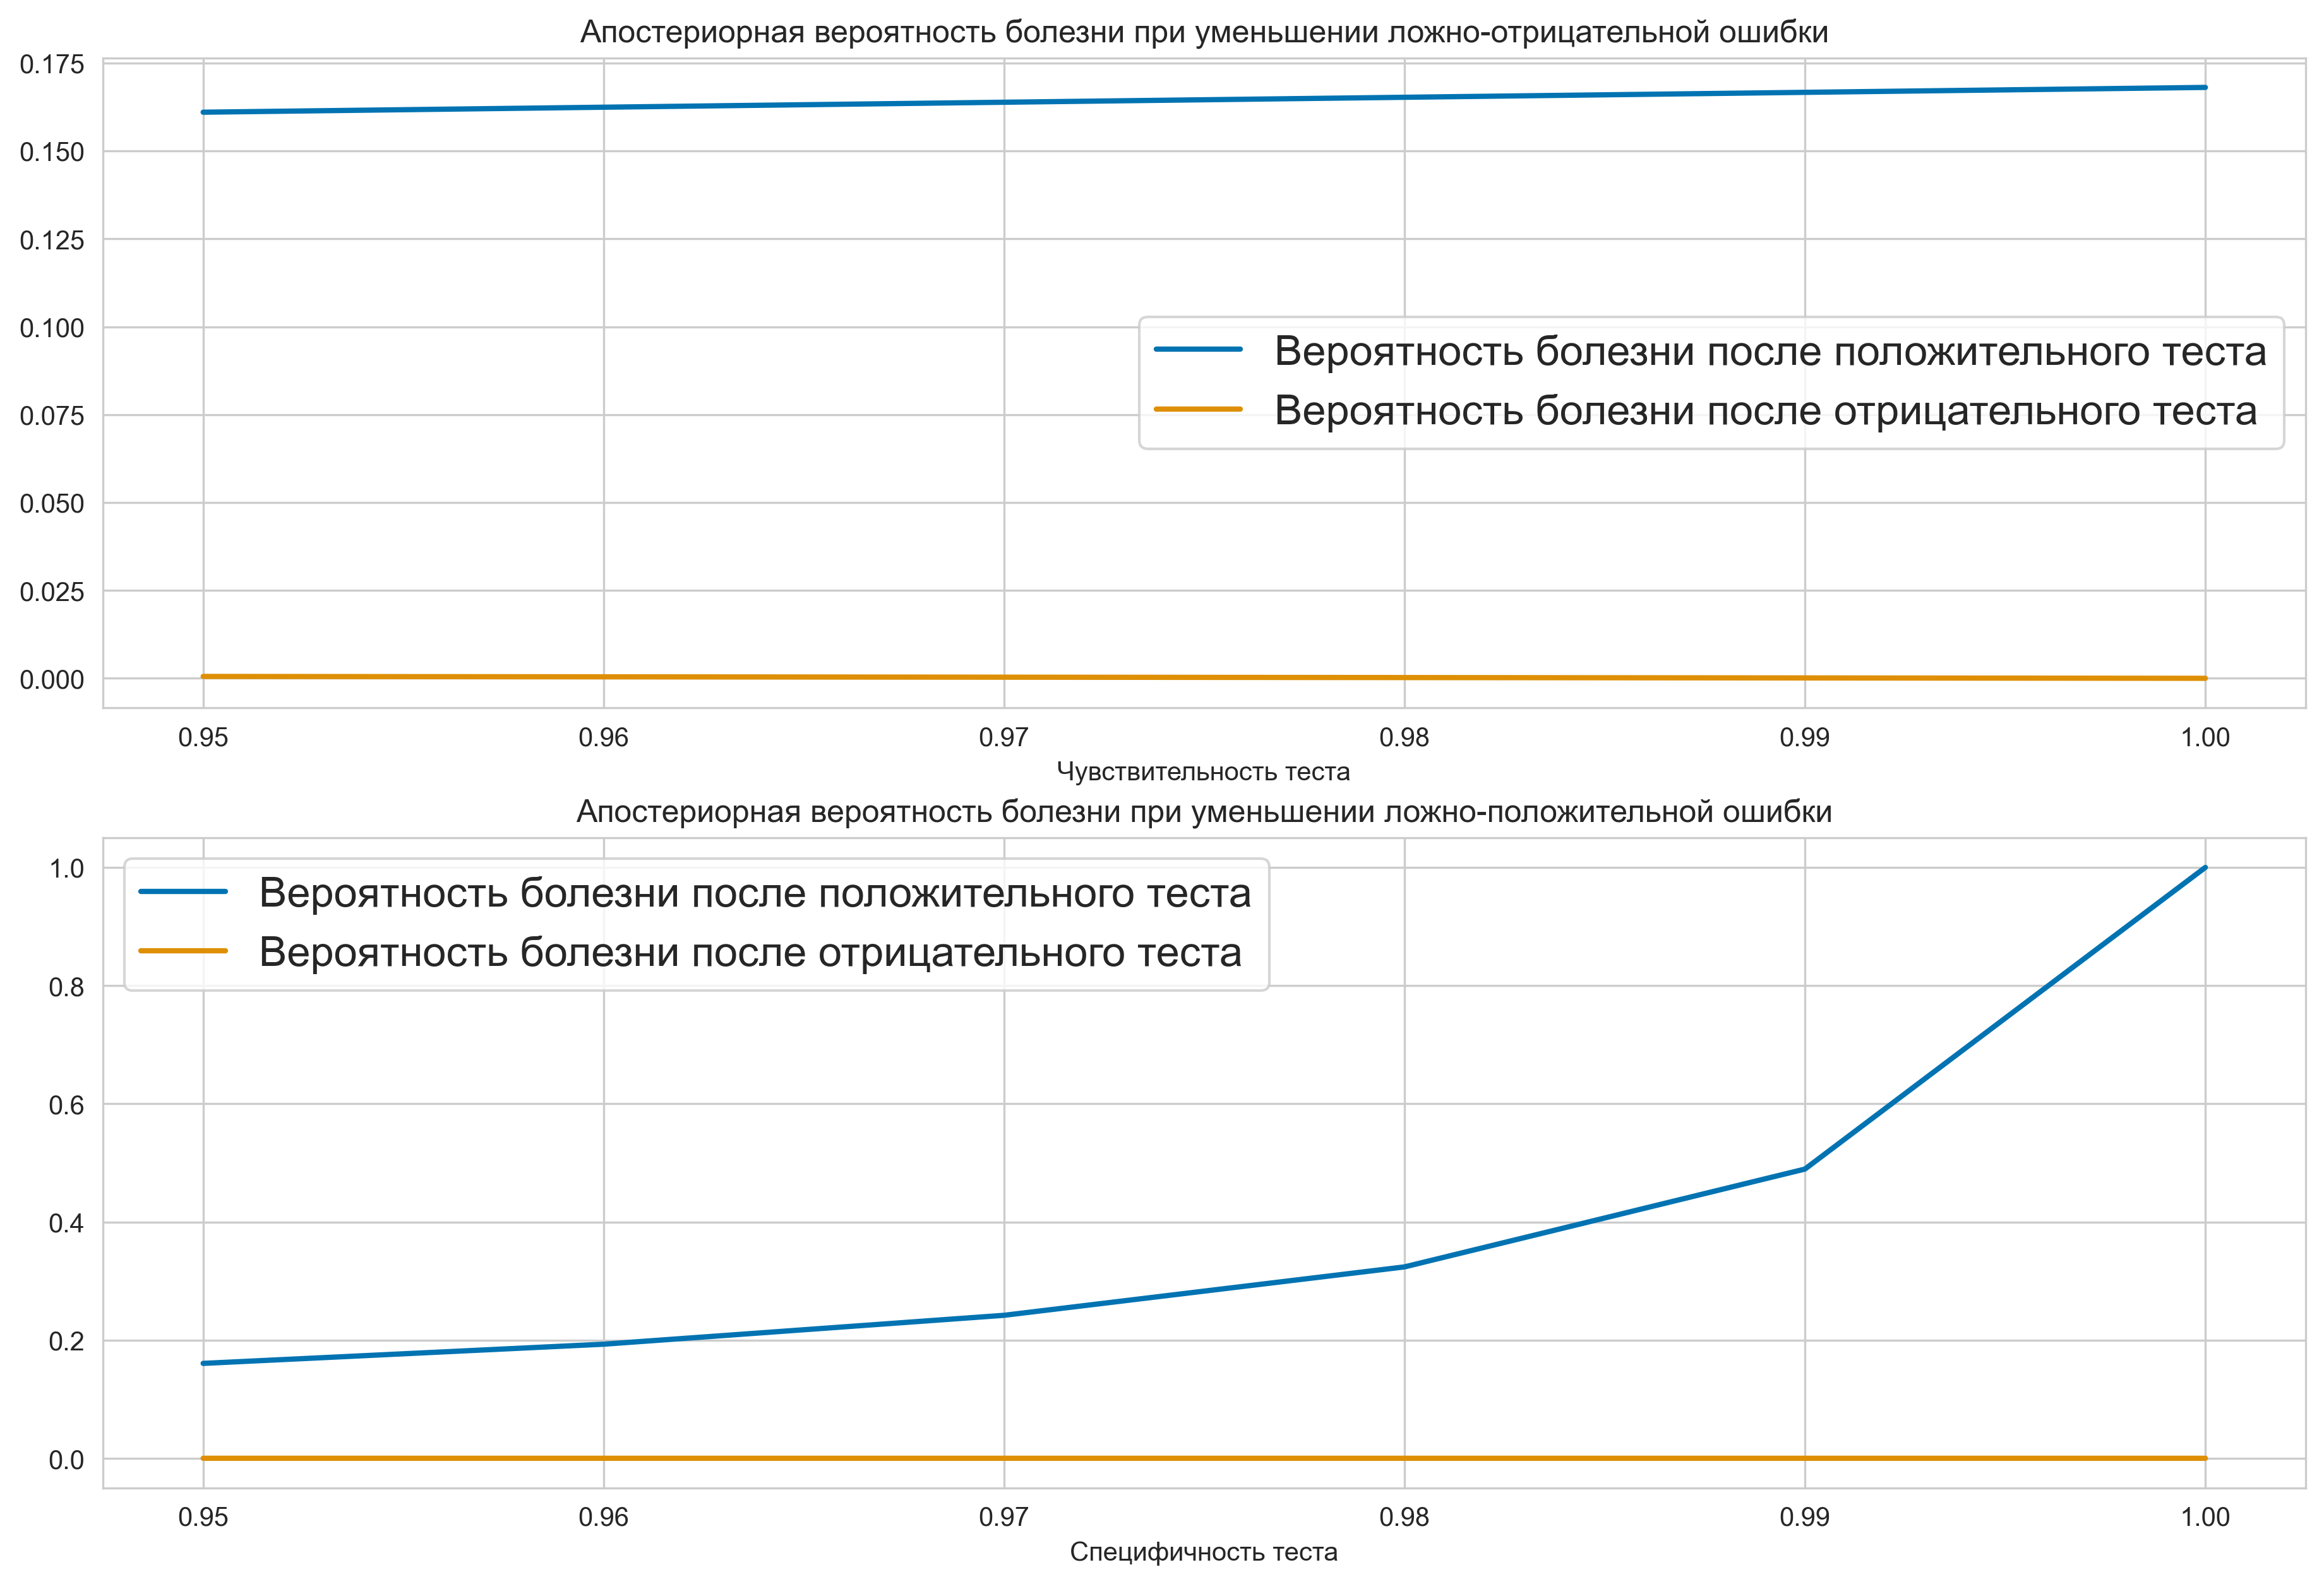

In [129]:
xs = np.arange(0.95, 1., 0.01)

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(211)
ax1.plot(xs, posterior_probabilty(1, accuracy=xs), linewidth=2, 
         label='Вероятность болезни после положительного теста')
ax1.plot(xs, posterior_probabilty(0, accuracy=xs), linewidth=2, 
         label='Вероятность болезни после отрицательного теста')
ax1.set_title('Апостериорная вероятность болезни при уменьшении ложно-отрицательной ошибки')
ax1.set_xlabel('Чувствительность теста')
ax1.legend(fontsize=legend_fontsize)

ax2 = fig.add_subplot(212)
ax2.plot(xs, posterior_probabilty(1, specificity=xs), linewidth=2,
         label='Вероятность болезни после положительного теста')
ax2.plot(xs, posterior_probabilty(0, specificity=xs), linewidth=2, 
         label='Вероятность болезни после отрицательного теста')
ax2.set_title('Апостериорная вероятность болезни при уменьшении ложно-положительной ошибки')
ax2.set_xlabel('Специфичность теста')
ax2.legend(fontsize=legend_fontsize)

plt.show()

Как видно из графиков, при уменьшении ложно-положительной ошибки (повышении специфичности) теста апостериорная вероятность болезни при положительном тесте стремится к 1, а апостериорная вероятность болезни при отрицательном результате теста равна 0. Таким образом, при уменьшении ложно-положительной ошибки можно почти наверняка утверждать о наличии или отсутствии болезни у пациента по результам тестирования. Подобного результата нельзя получить при уменьшении ложно-отрицательной ошибки, поэтому врачам стоит сконцентрироваться на числе false positives. 

# Линейная регрессия

In [52]:
TRAIN_SIZE = 50

In [53]:
df = pd.read_csv('owid-covid-data.csv', parse_dates=['date'])

In [54]:
df.new_cases = df.new_cases.replace(0, 1)

In [55]:
main_df = df[(df.location == 'Russia') & (df.date >= '2020-03-03')]
main_df['num_day'] = np.arange(len(main_df))
main_df['num_days_squared'] = main_df['num_day'] ** 2
main_df.head()

<ipython-input-55-71da487c9782>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['num_day'] = np.arange(len(main_df))
<ipython-input-55-71da487c9782>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  main_df['num_days_squared'] = main_df['num_day'] ** 2


iso_code continent location       date  total_cases  new_cases  \
52438      RUS    Europe   Russia 2020-03-03          3.0        1.0   
52439      RUS    Europe   Russia 2020-03-04          3.0        1.0   
52440      RUS    Europe   Russia 2020-03-05          4.0        1.0   
52441      RUS    Europe   Russia 2020-03-06         13.0        9.0   
52442      RUS    Europe   Russia 2020-03-07         13.0        1.0   

       new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
52438               0.143           NaN         NaN                  0.0  ...   
52439               0.143           NaN         NaN                  0.0  ...   
52440               0.286           NaN         NaN                  0.0  ...   
52441               1.571           NaN         NaN                  0.0  ...   
52442               1.571           NaN         NaN                  0.0  ...   

       cardiovasc_death_rate  diabetes_prevalence  female_smokers  \
52438                431.297                 6.18            23.4   
52439                431.297                 6.18            23.4   
52440                431.297                 6.18            23.4   
52441                431.297                 6.18            23.4   
52442                431.297                 6.18            23.4   

       male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
52438          58.3                     NaN                        8.05   
52439          58.3                     NaN                        8.05   
52440          58.3                     NaN                        8.05   
52441          58.3                     NaN                        8.05   
52442          58.3                     NaN                        8.05   

       life_expectancy  human_development_index  num_day  num_days_squared  
52438            72.58                    0.824        0                 0  
52439            72.58                    0.824        1                 1  
52440            72.58                    0.824        2                 4  
52441            72.58                    0.824        3                 9  
52442            72.58                    0.824        4                16  

[5 rows x 61 columns]

In [56]:
train, test = main_df[:TRAIN_SIZE], main_df[TRAIN_SIZE:]
train.shape, test.shape

((50, 61), (308, 61))

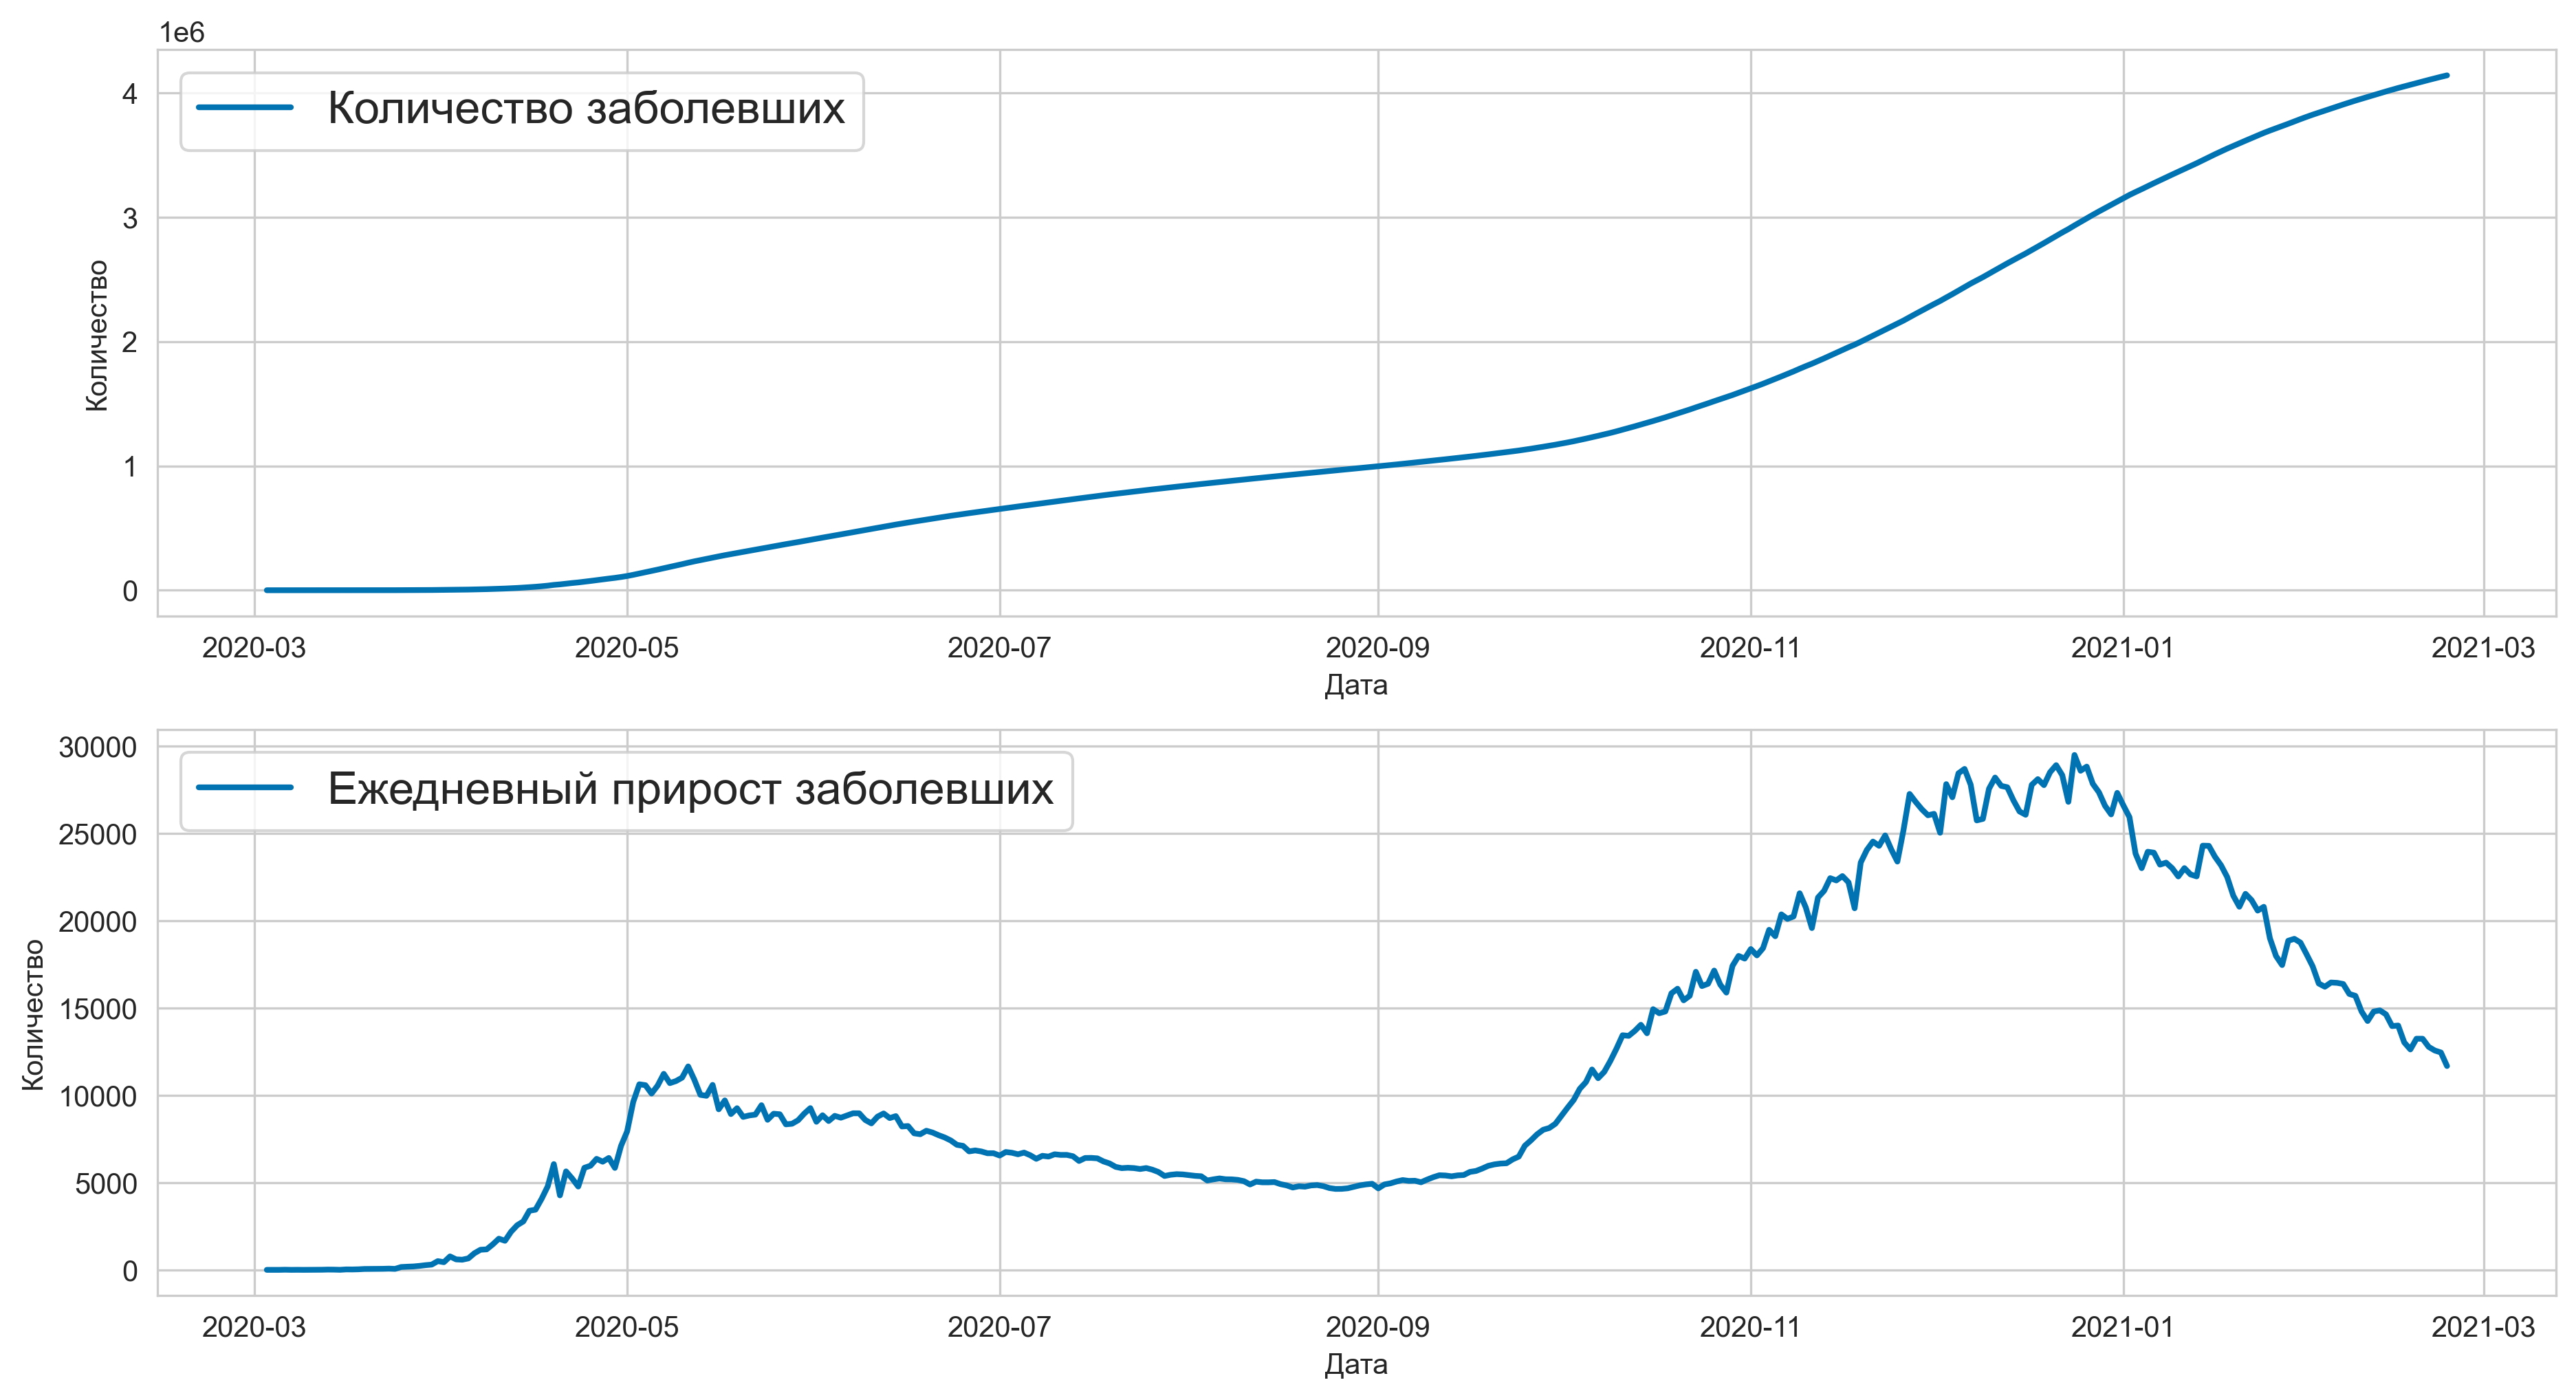

In [57]:
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(211)
ax1.plot(main_df.date.values, main_df.total_cases.values, linewidth=2, label='Количество заболевших')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Количество')
ax1.legend(fontsize=legend_fontsize)

ax2 = fig.add_subplot(212)
ax2.plot(main_df.date.values, main_df.new_cases.values, linewidth=2, label='Ежедневный прирост заболевших')
ax2.legend(fontsize=legend_fontsize)
ax2.set_xlabel('Дата')
ax2.set_ylabel('Количество')

plt.show()

## Экспоненциальная модель

Рассмотрим модель экспоненциального роста числа заболевших вида:
$$y \sim e^{\bar{w}^T\bar{x}}$$
Для удобства обучения модели сведем ее к модели линейной регрессии путем логарифмирования обеих частей модели экспоненциального роста:
$$ln(y) \sim \bar{w}^T\bar{x},$$
где x - номер текущего дня.

## 2a

In [58]:
model = LinearRegression()
model.fit(train.num_day.values.reshape(-1, 1), np.log(train.total_cases.values))
print(f'Коэффициенты модели линейной регрессии: {(model.intercept_, model.coef_[0])}')

Коэффициенты модели линейной регрессии: (1.8207371487846977, 0.19829091233588558)


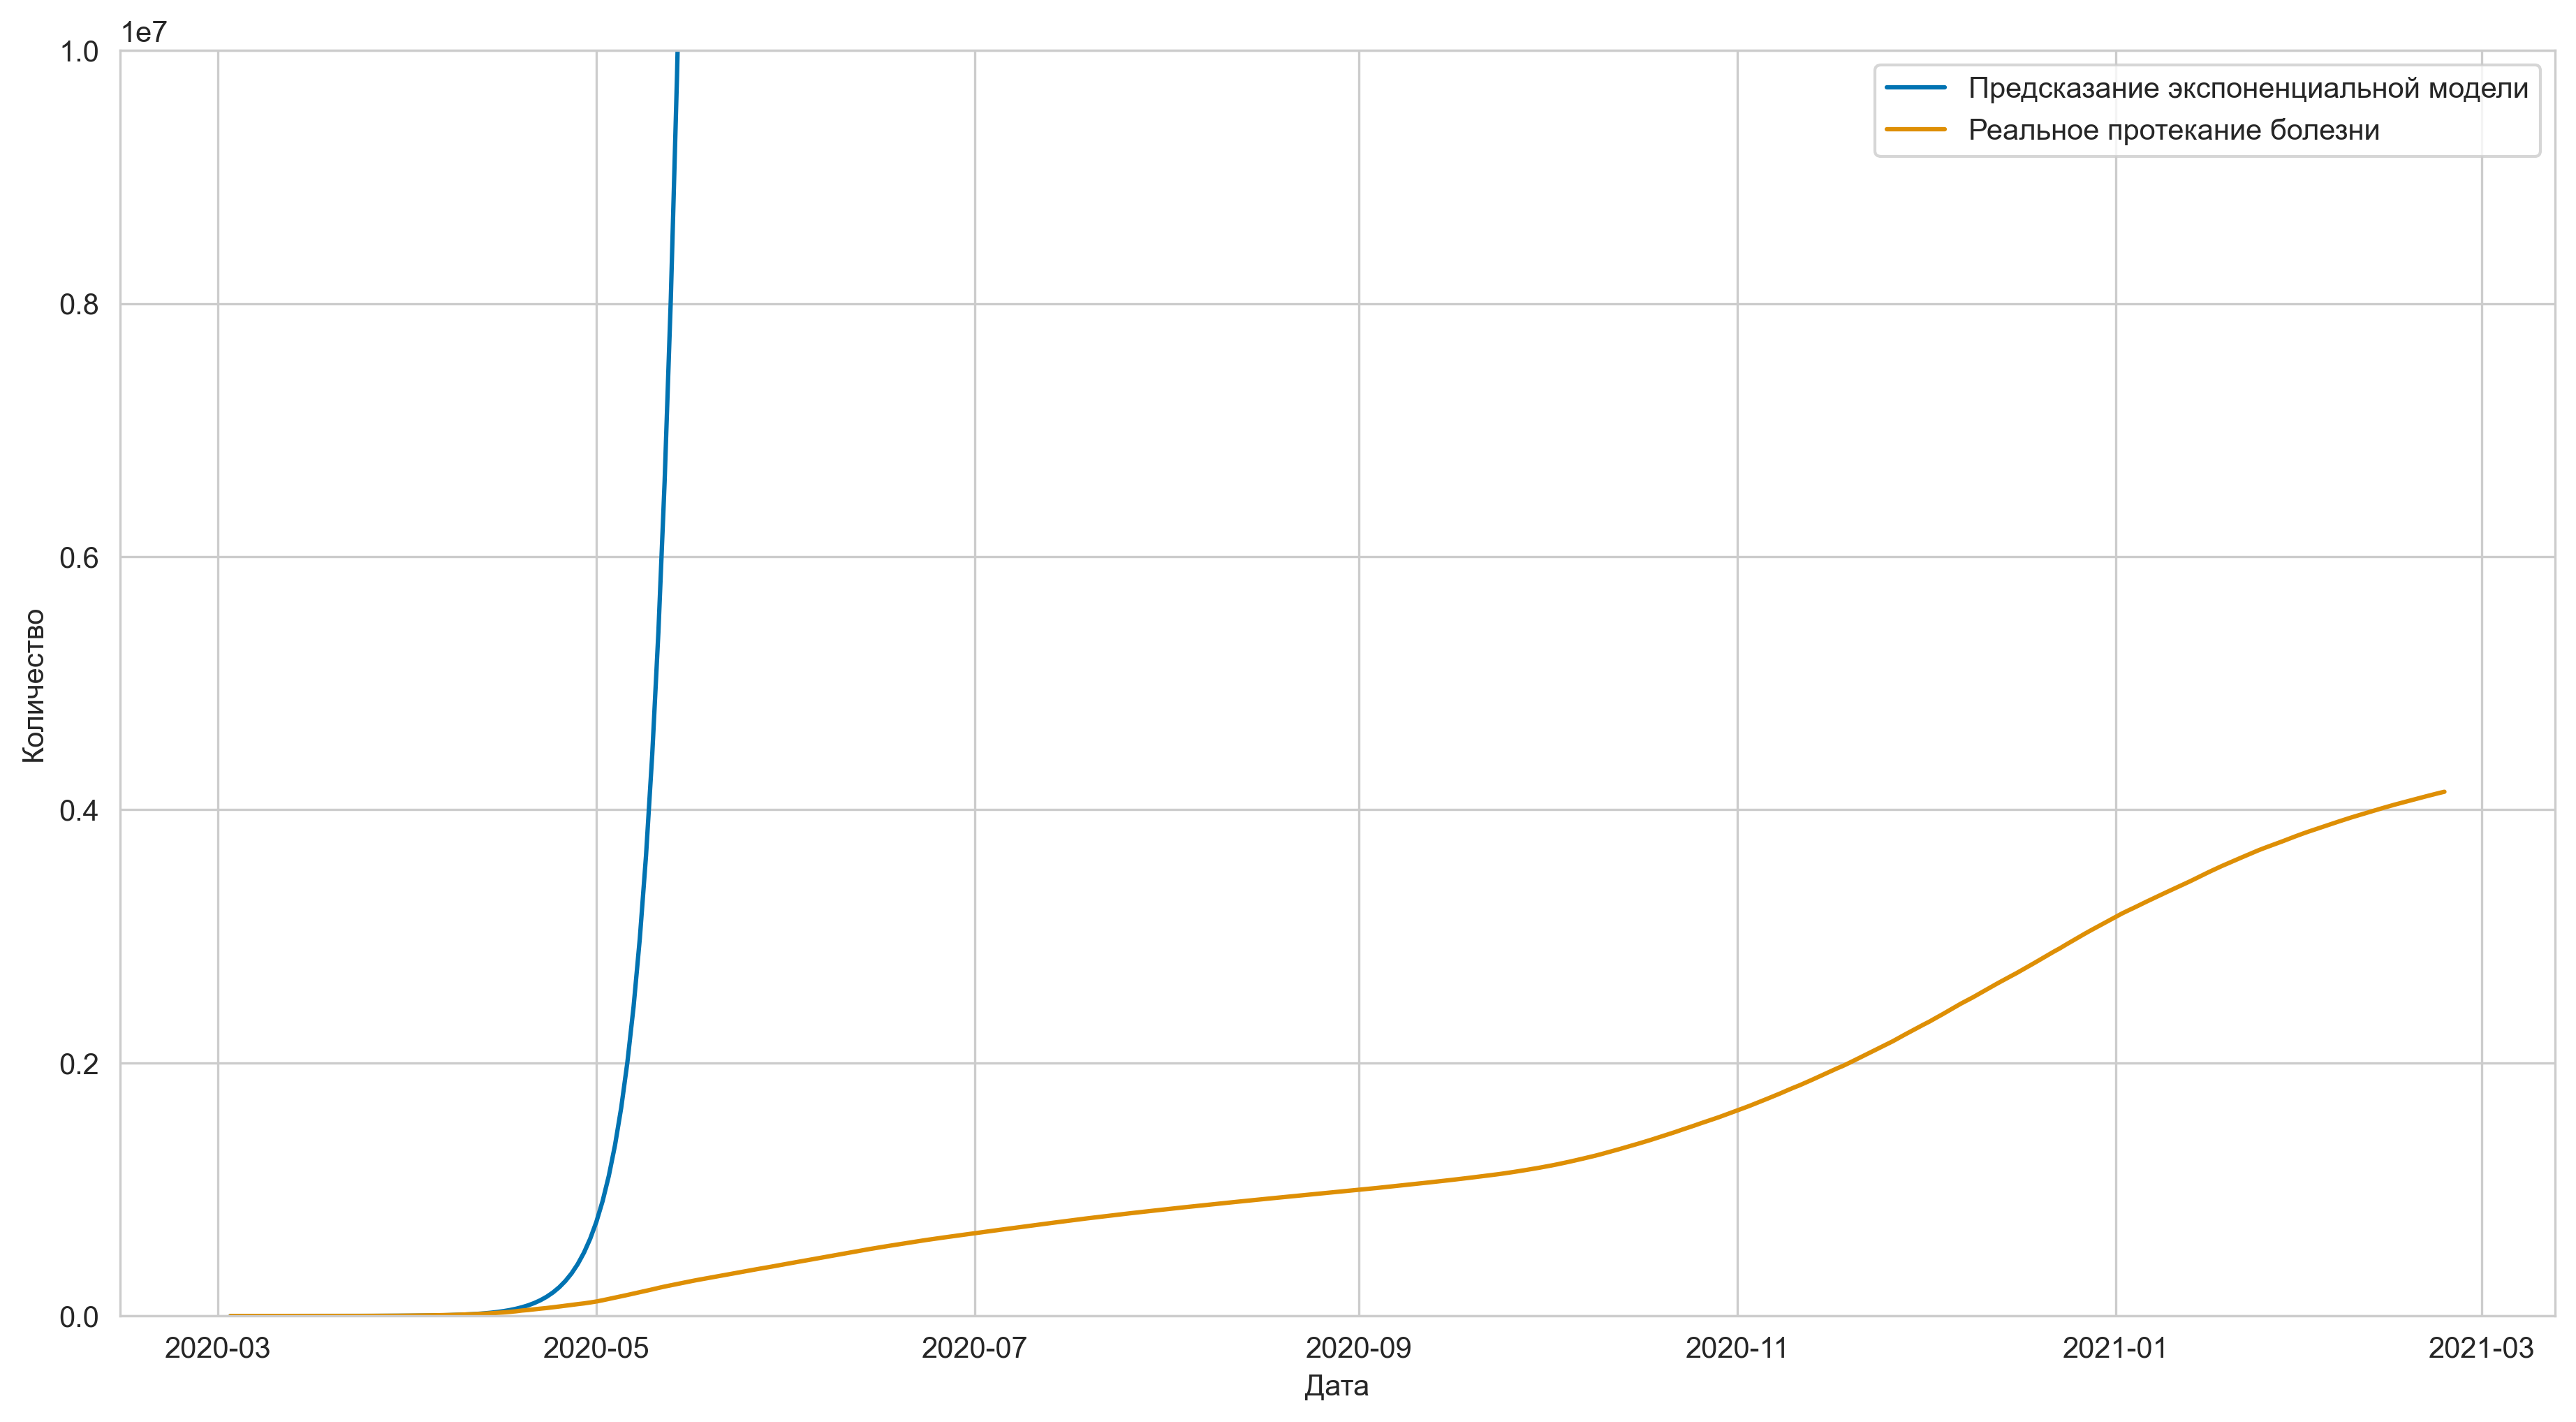

In [59]:
plt.plot(main_df.date, np.exp(model.predict(main_df.num_day.values.reshape(-1, 1))), 
         label='Предсказание экспоненциальной модели')
plt.plot(main_df.date, main_df.total_cases.values, label='Реальное протекание болезни')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.ylim(0, 1e7)
plt.legend()
plt.show()

## 2b

In [60]:
preds = model.predict(train.num_day.values.reshape(-1, 1))
sigma_noise = np.sqrt(np.sum((preds - np.log(train.total_cases.values)) ** 2) / len(train))
print('Среднеквадратическое отклонение шума в данных %.4f' % sigma_noise)

Среднеквадратическое отклонение шума в данных 0.3490


In [61]:
N = 250
X = np.linspace(-1, 1, N)
Y = np.linspace(-1, 1, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def plot_heatmap(Z, title, xlim=(-1, 1), ylim=(-1, 1), point=None):
#     Heatmap гауссиана
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('$w_0$')
    plt.ylabel('$w_1$')
    plt.pcolormesh(X, Y, Z, cmap=plt.cm.jet)
    plt.title(title)
    if point is not None:
        plt.scatter(point[0], point[1], marker='*', s=120, color='white')

(250, 250)


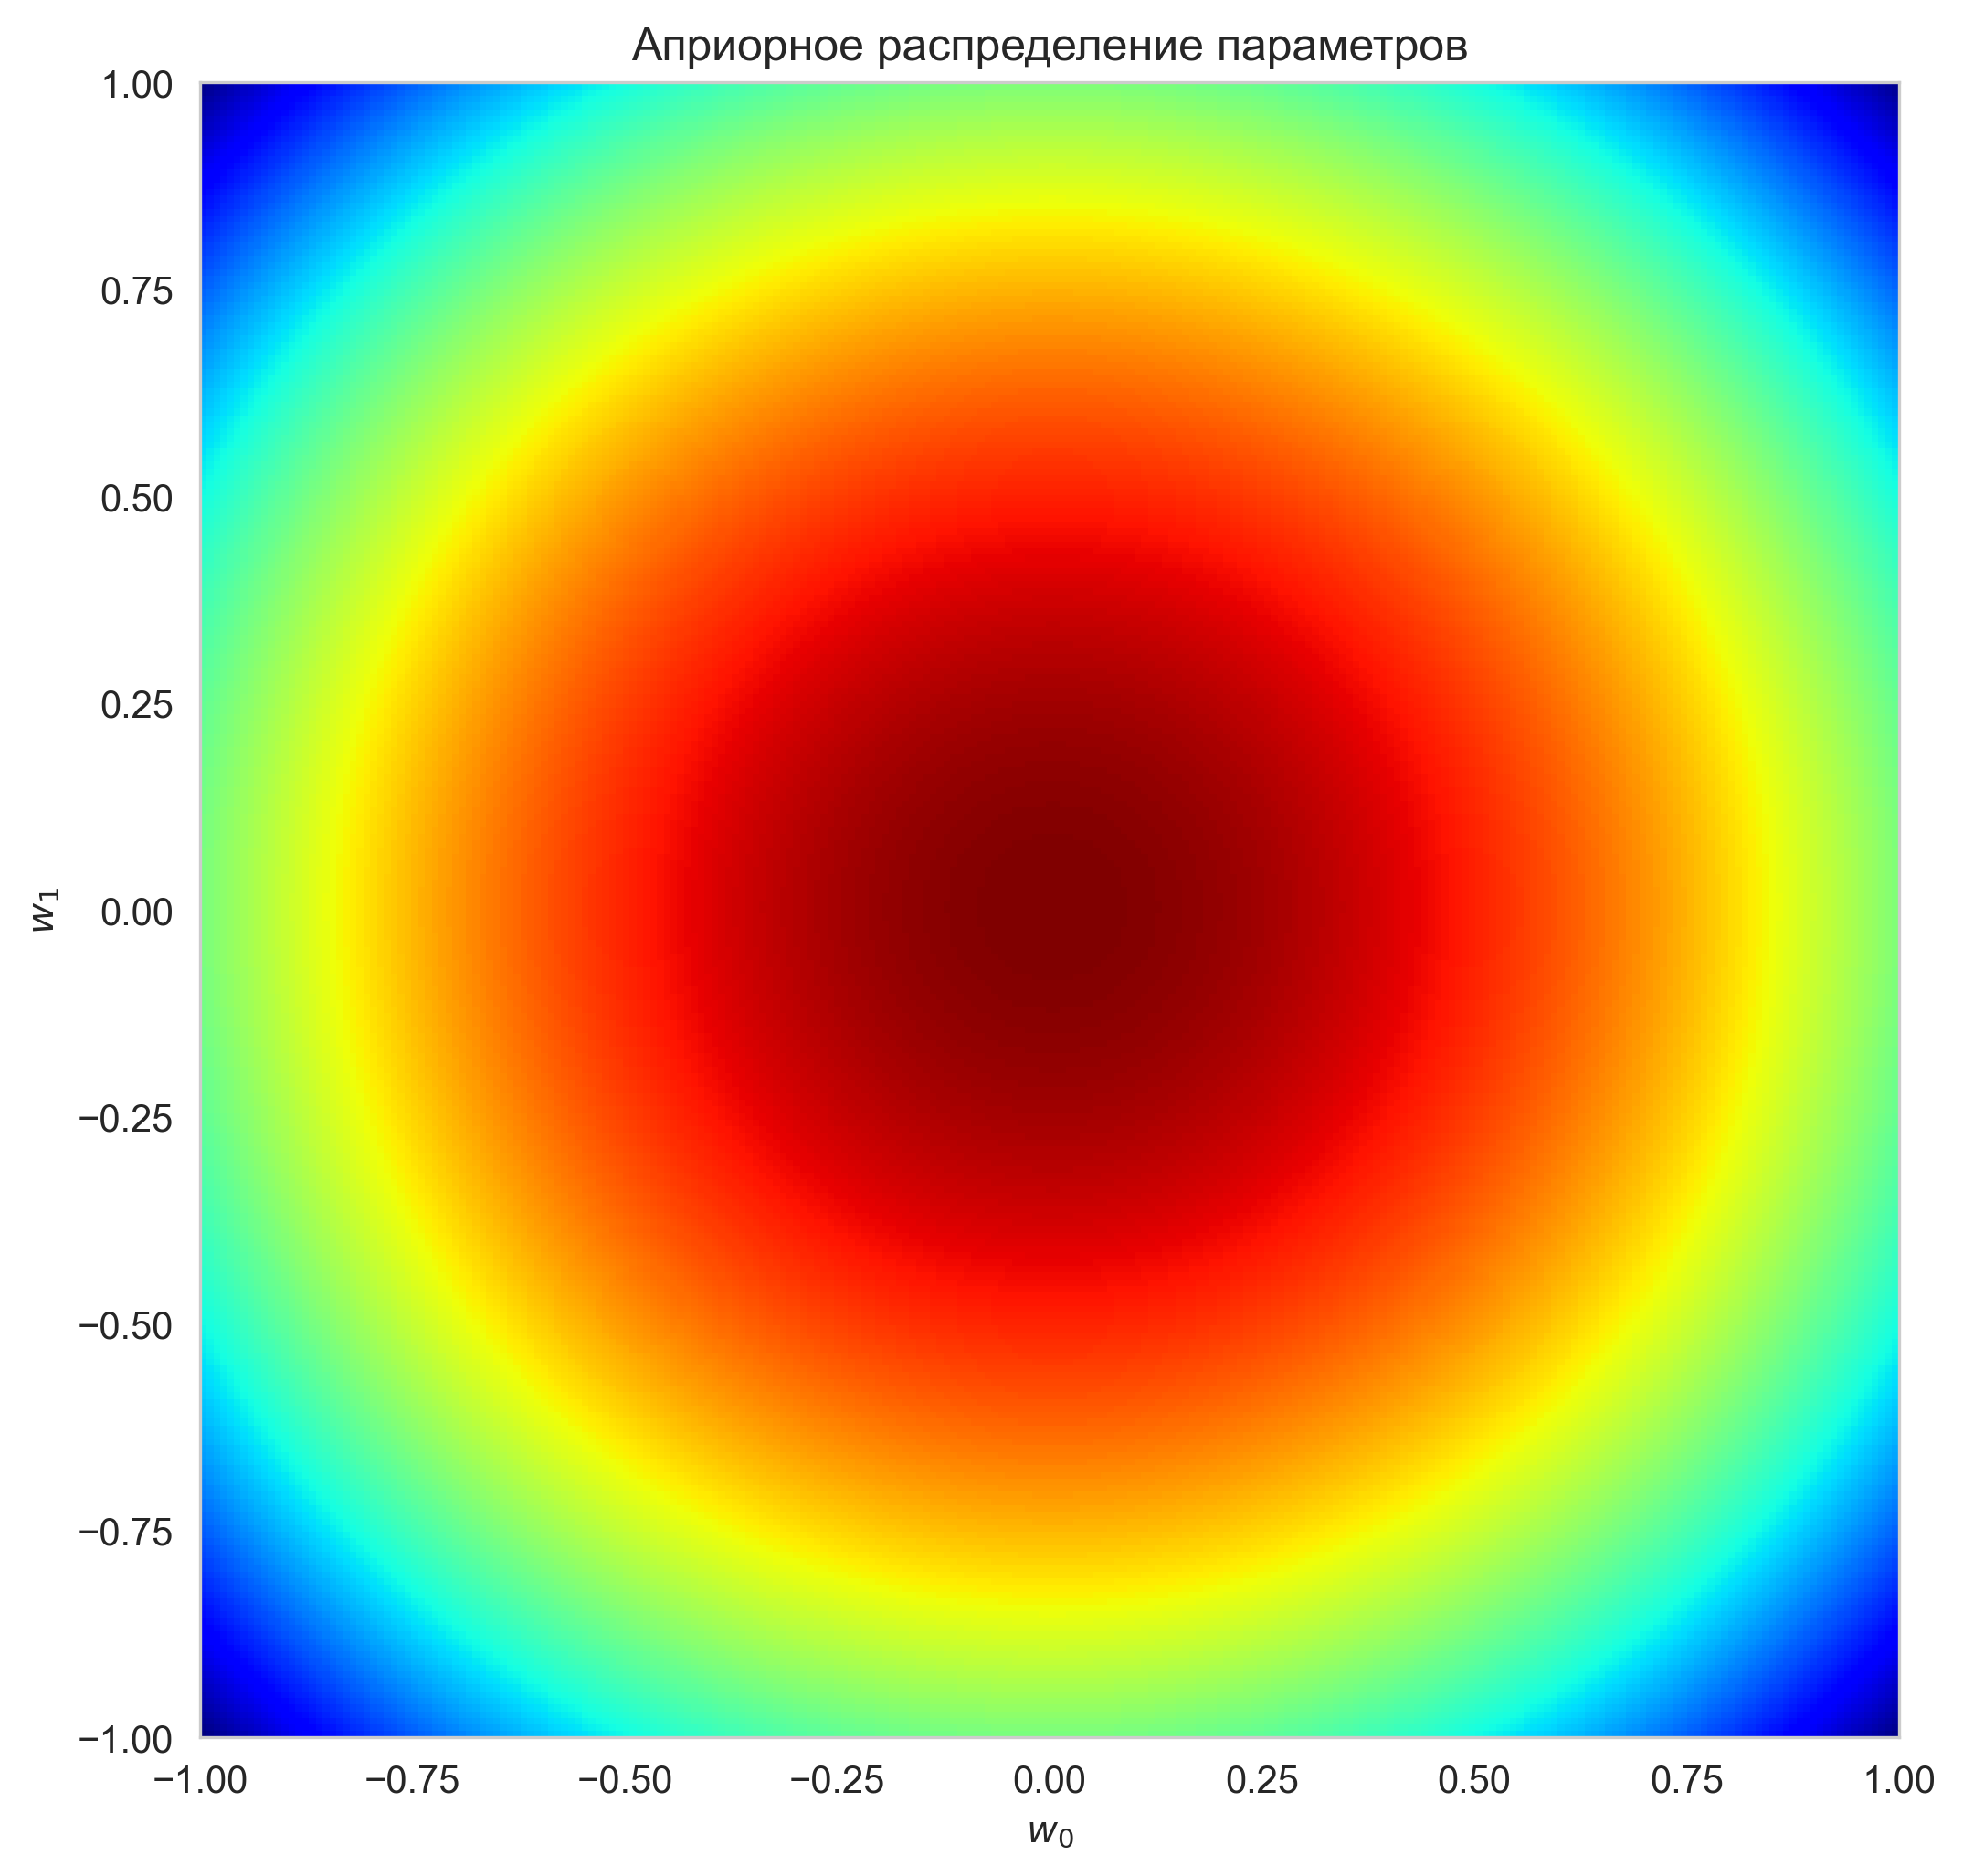

In [62]:
# Мат. ожидание и ковариационная матрица априорного распредления
cur_mu, cur_sigma = np.array([0, 0]), np.array([[100, 0], [0, 100]])

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
print(Z.shape)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))
plot_heatmap(Z, title='Априорное распределение параметров')

In [63]:
def get_likelihood(px, py, sigma=sigma_noise):
#     Получение правдоподобия в одной точке
    return lambda x : np.exp((-(x[0] + x[1]*px - py) ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2. * np.pi))

def bayesian_update(mu, sigma, x, y, sigma_noise=sigma_noise):
#     Шаг байесовского вывода
    x_matrix = np.array([[1., x]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n


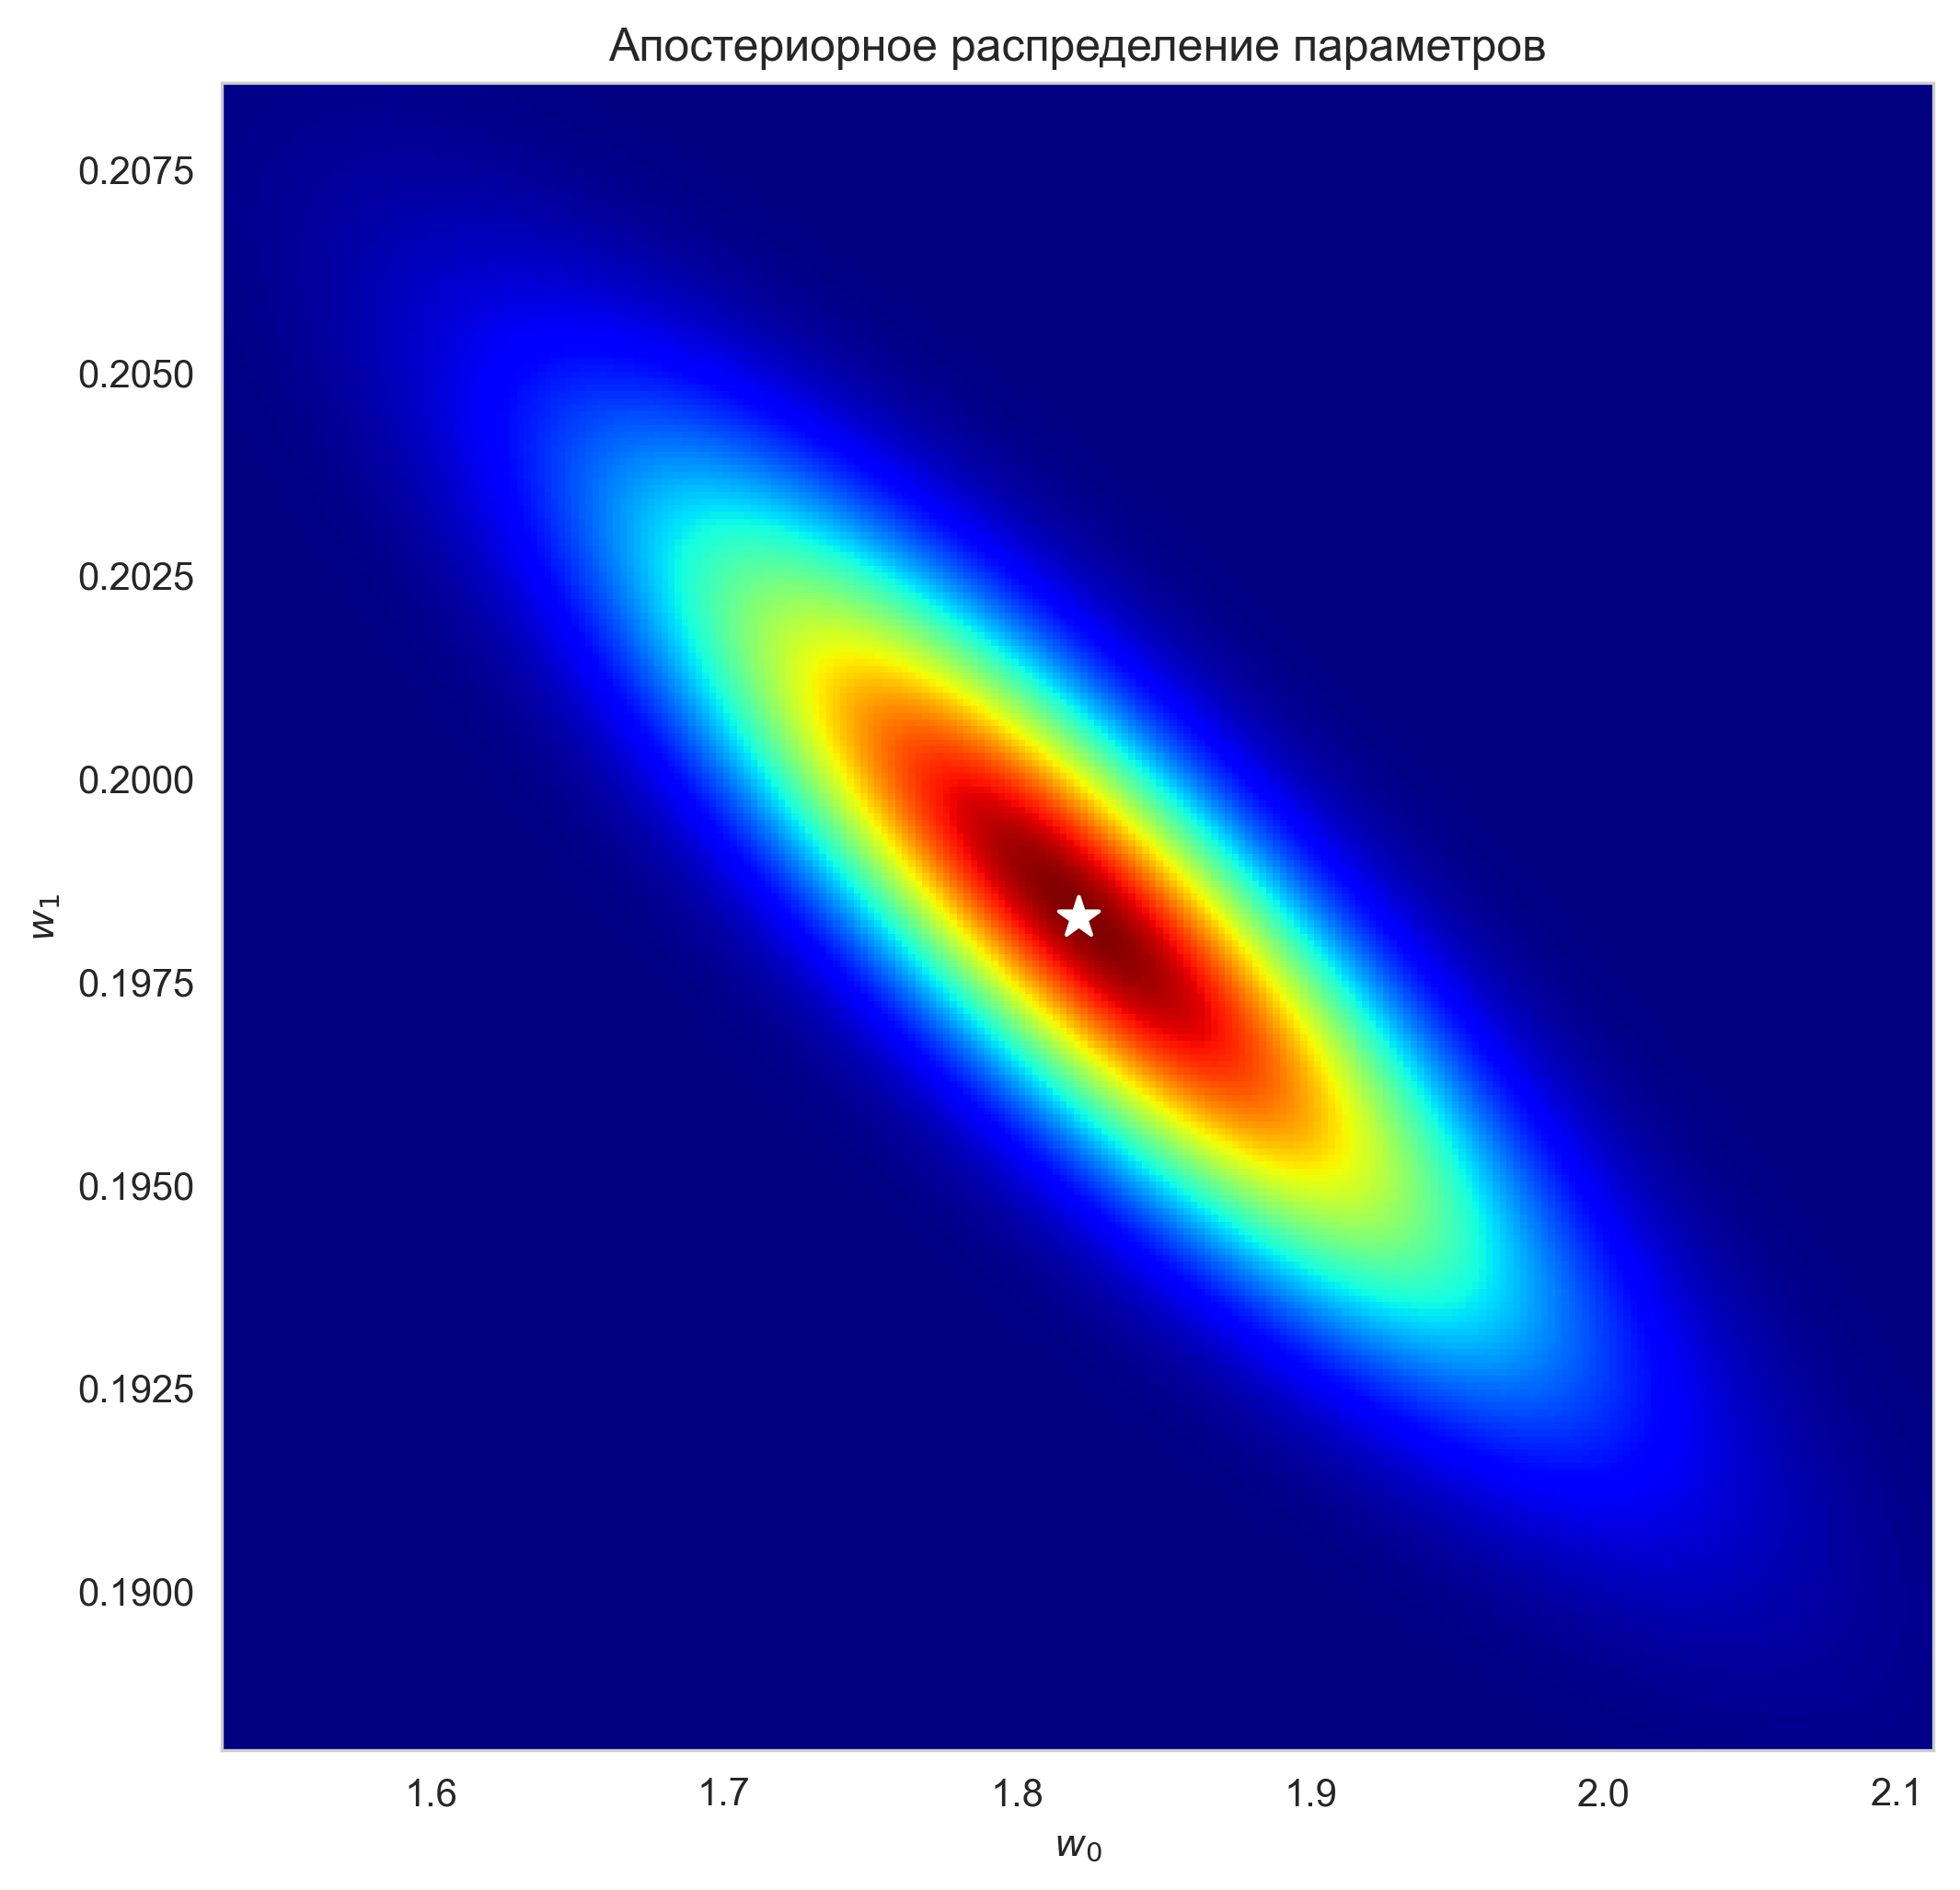

In [64]:
x_list, y_list = train.num_day.values, np.log(train.total_cases.values)

for i in range(len(train)):
#     cur_likelihood = get_likelihood(x_list[i], y_list[i])
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, x_list[i], y_list[i])
    

s0, s1 = 3 * np.sqrt(cur_sigma.diagonal())
X = np.linspace(cur_mu[0] - s0, cur_mu[0] + s0, N)
Y = np.linspace(cur_mu[1] - s1, cur_mu[1] + s1, N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

Z = multivariate_normal.pdf(pos, mean=cur_mu, cov=cur_sigma)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_xlim((cur_mu[0] - s0, cur_mu[0] + s0))
ax.set_ylim((cur_mu[1] - s1, cur_mu[1] + s1))
p = (model.intercept_, model.coef_[0])
plot_heatmap(Z, title='Апостериорное распределение параметров', xlim=(cur_mu[0] - s0, cur_mu[0] + s0), 
             ylim=(cur_mu[1] - s1, cur_mu[1] + s1), point=p)

In [65]:
# Белая звездочка - параметры модели LinearRegression, обученной в начале раздела
print('Параметры модели линейной регрессии (белая звездочка): (%.4f, %.4f)' % (model.intercept_, model.coef_[0]))
print('Мат. ожидание апостериорного распределения параметров: (%.4f, %.4f)' % tuple(cur_mu))

Параметры модели линейной регрессии (белая звездочка): (1.8207, 0.1983)
Мат. ожидание апостериорного распределения параметров: (1.8206, 0.1983)


## 2c

In [66]:
# Мат. ожидание и среднеквадратическое отклонение предсказательного распределения
pred_mu = lambda x: cur_mu[0] + cur_mu[1] * x
pred_sigma = lambda x: np.sqrt(sigma_noise ** 2 + (np.array([[1., x]]).dot(cur_sigma)).dot(np.array([[1., x]]).T)[0][0]) 

In [67]:
def sample_lines(df, mu, sigma, xs, n=20):
    may_day = df[df.date == '2020-05-01'].num_day.iloc[0]
    june_day = df[df.date == '2020-06-01'].num_day.iloc[0]
    sept_day = df[df.date == '2020-09-01'].num_day.iloc[0]
    may_cnt, june_cnt, sept_cnt = [], [], []
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    
    for i, w in enumerate(my_w):
        res[i,:] = w[0] + w[1]*xs
        exp_model = np.exp(w[0] + w[1]*df.num_day.values)
        plt.plot(df.num_day.values, exp_model, 'k-', lw=.4)
        plt.xlabel('Номер дня')
        plt.ylabel('Количество заболевших')
        plt.title('Графики количества заболевших, предсказанного моделями с сэмплированными параметрами')
        
        may_cnt.append(exp_model[may_day])
        june_cnt.append(exp_model[june_day])
        sept_cnt.append(exp_model[sept_day])
    
    print('Расчет по данным сэмплирования:')
    print(f'Количество заболевших к 1 мая 2020 года: {int(np.mean(may_cnt))}')
    print(f'Количество заболевших к 1 июня 2020 года: {int(np.mean(june_cnt))}')
    print(f'Количество заболевших к 1 сентября 2020 года: {int(np.mean(sept_cnt))}')
                           
    return res

Расчет по данным сэмплирования:
Количество заболевших к 1 мая 2020 года: 747372
Количество заболевших к 1 июня 2020 года: 353938077
Количество заболевших к 1 сентября 2020 года: 32862543736267776


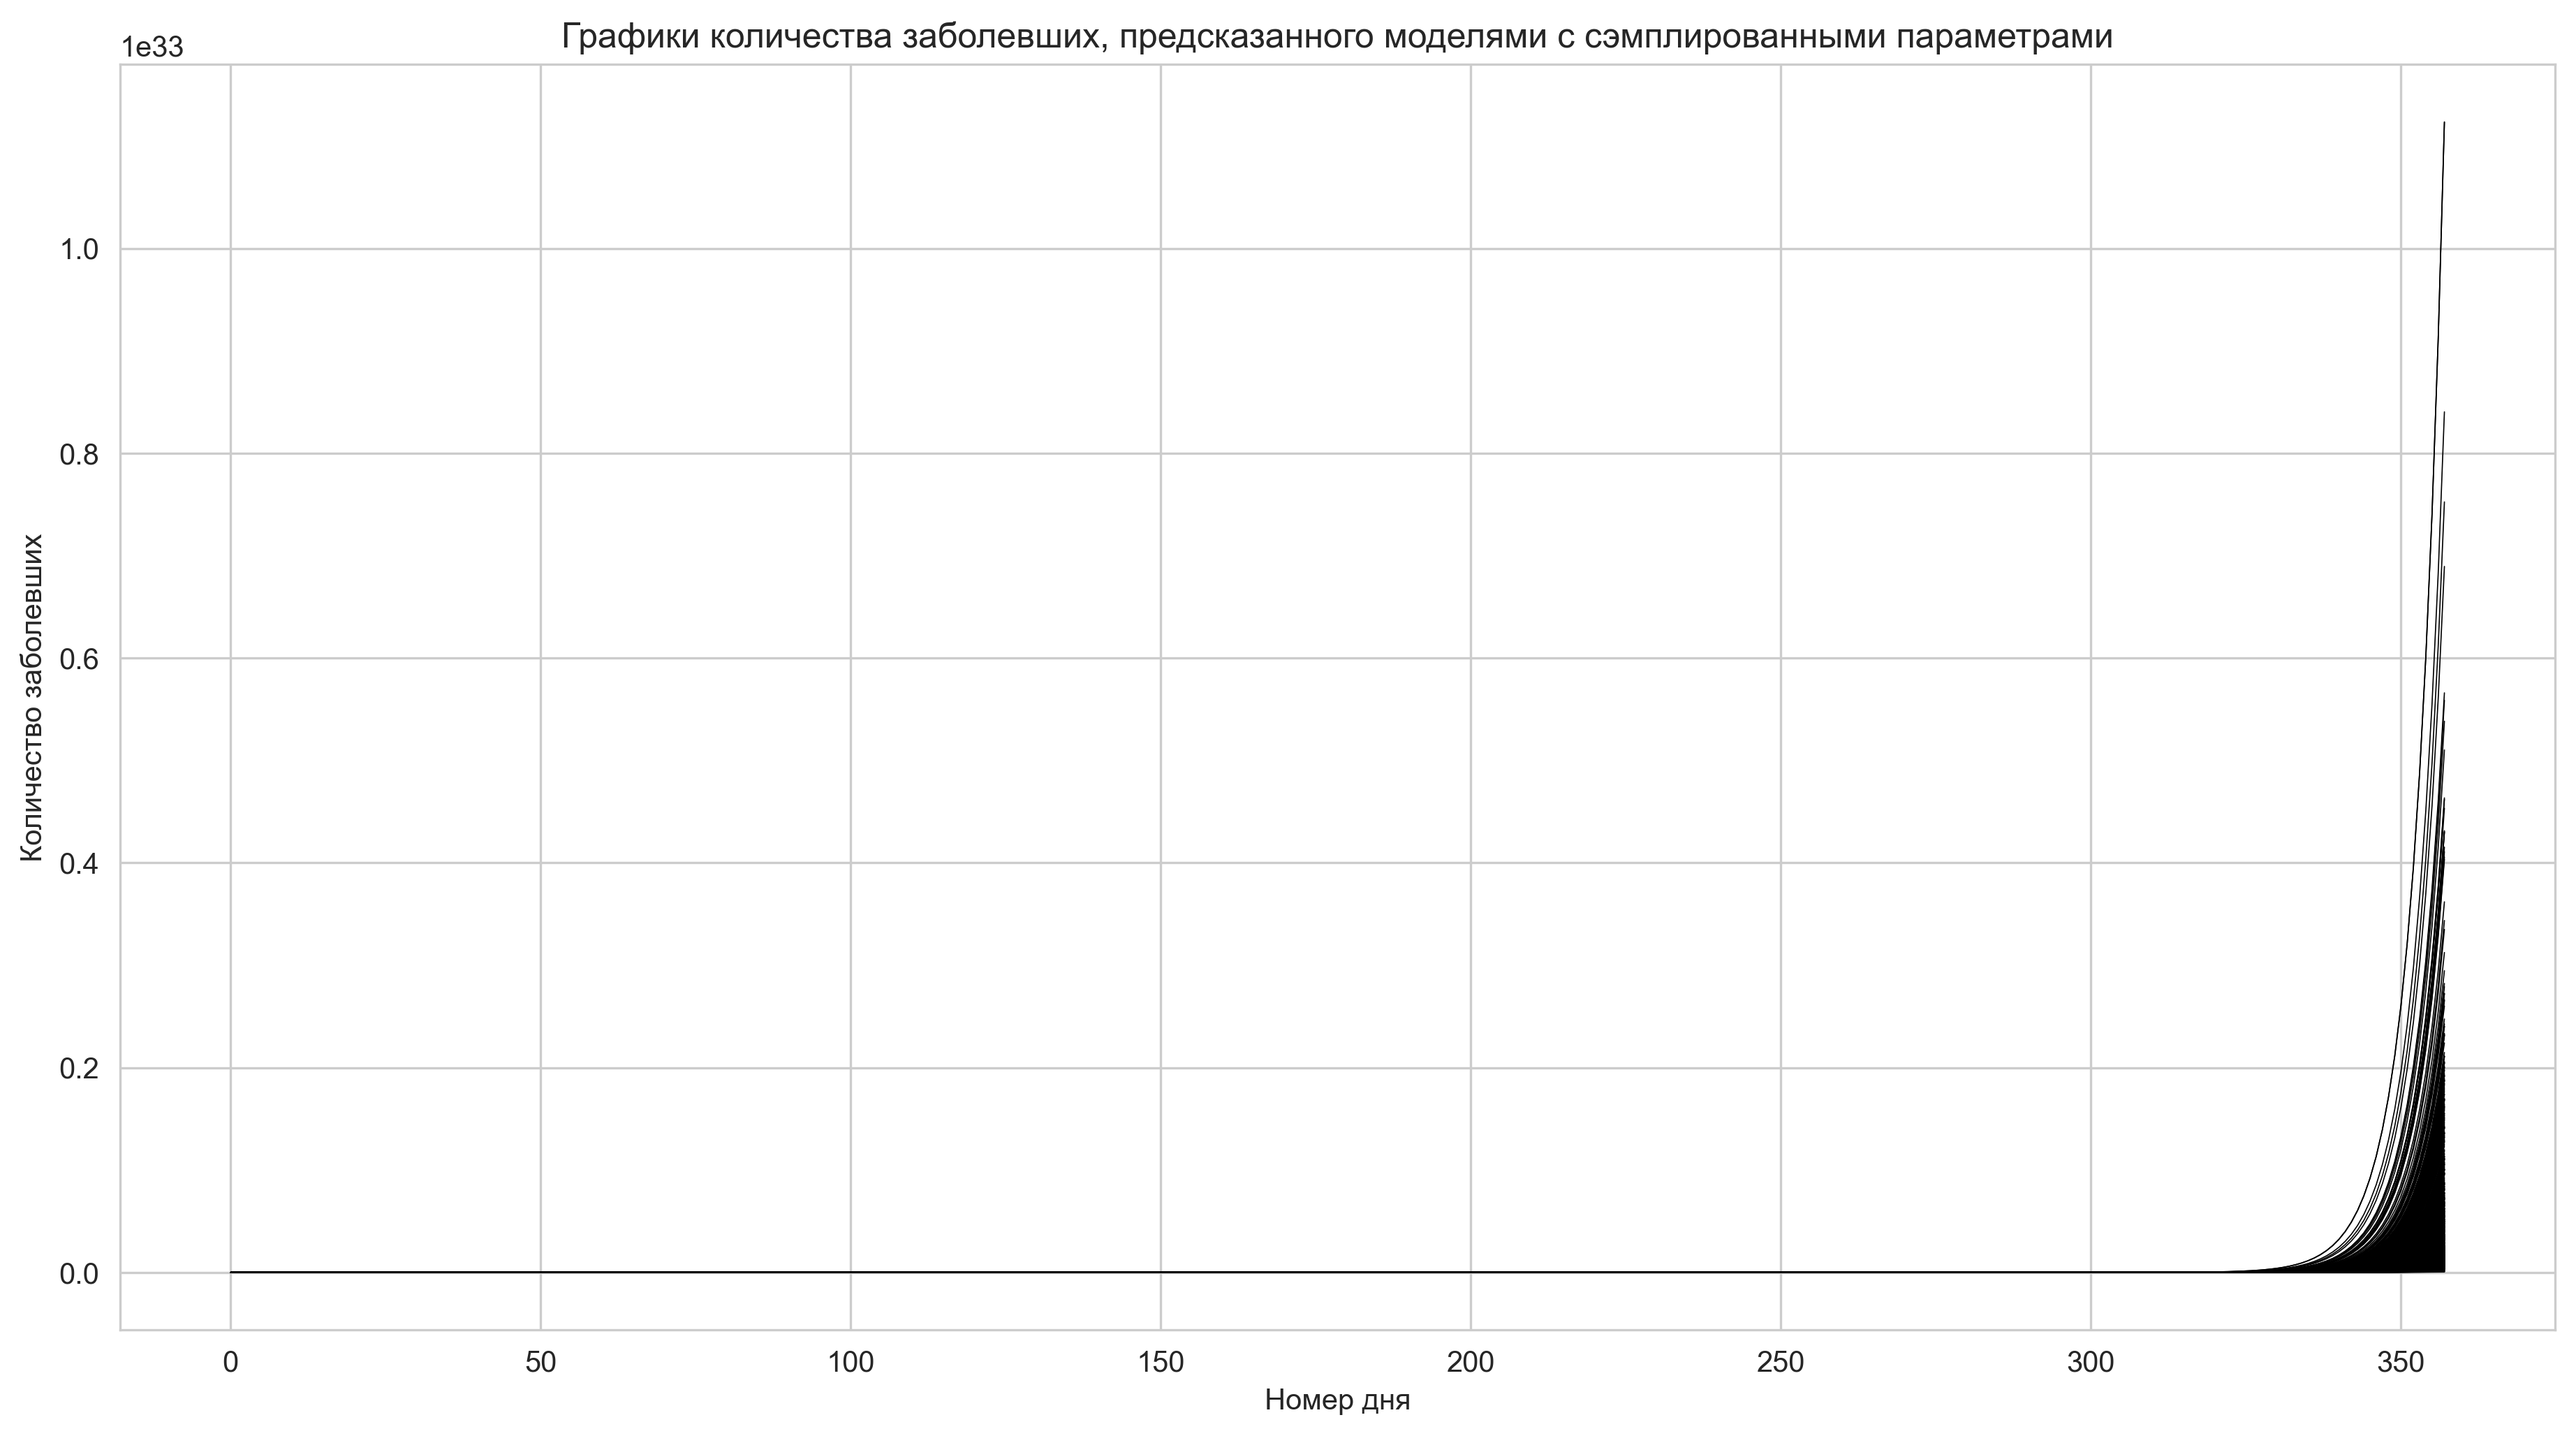

In [68]:
x = sample_lines(main_df, cur_mu, cur_sigma, np.arange(100), n=1000)

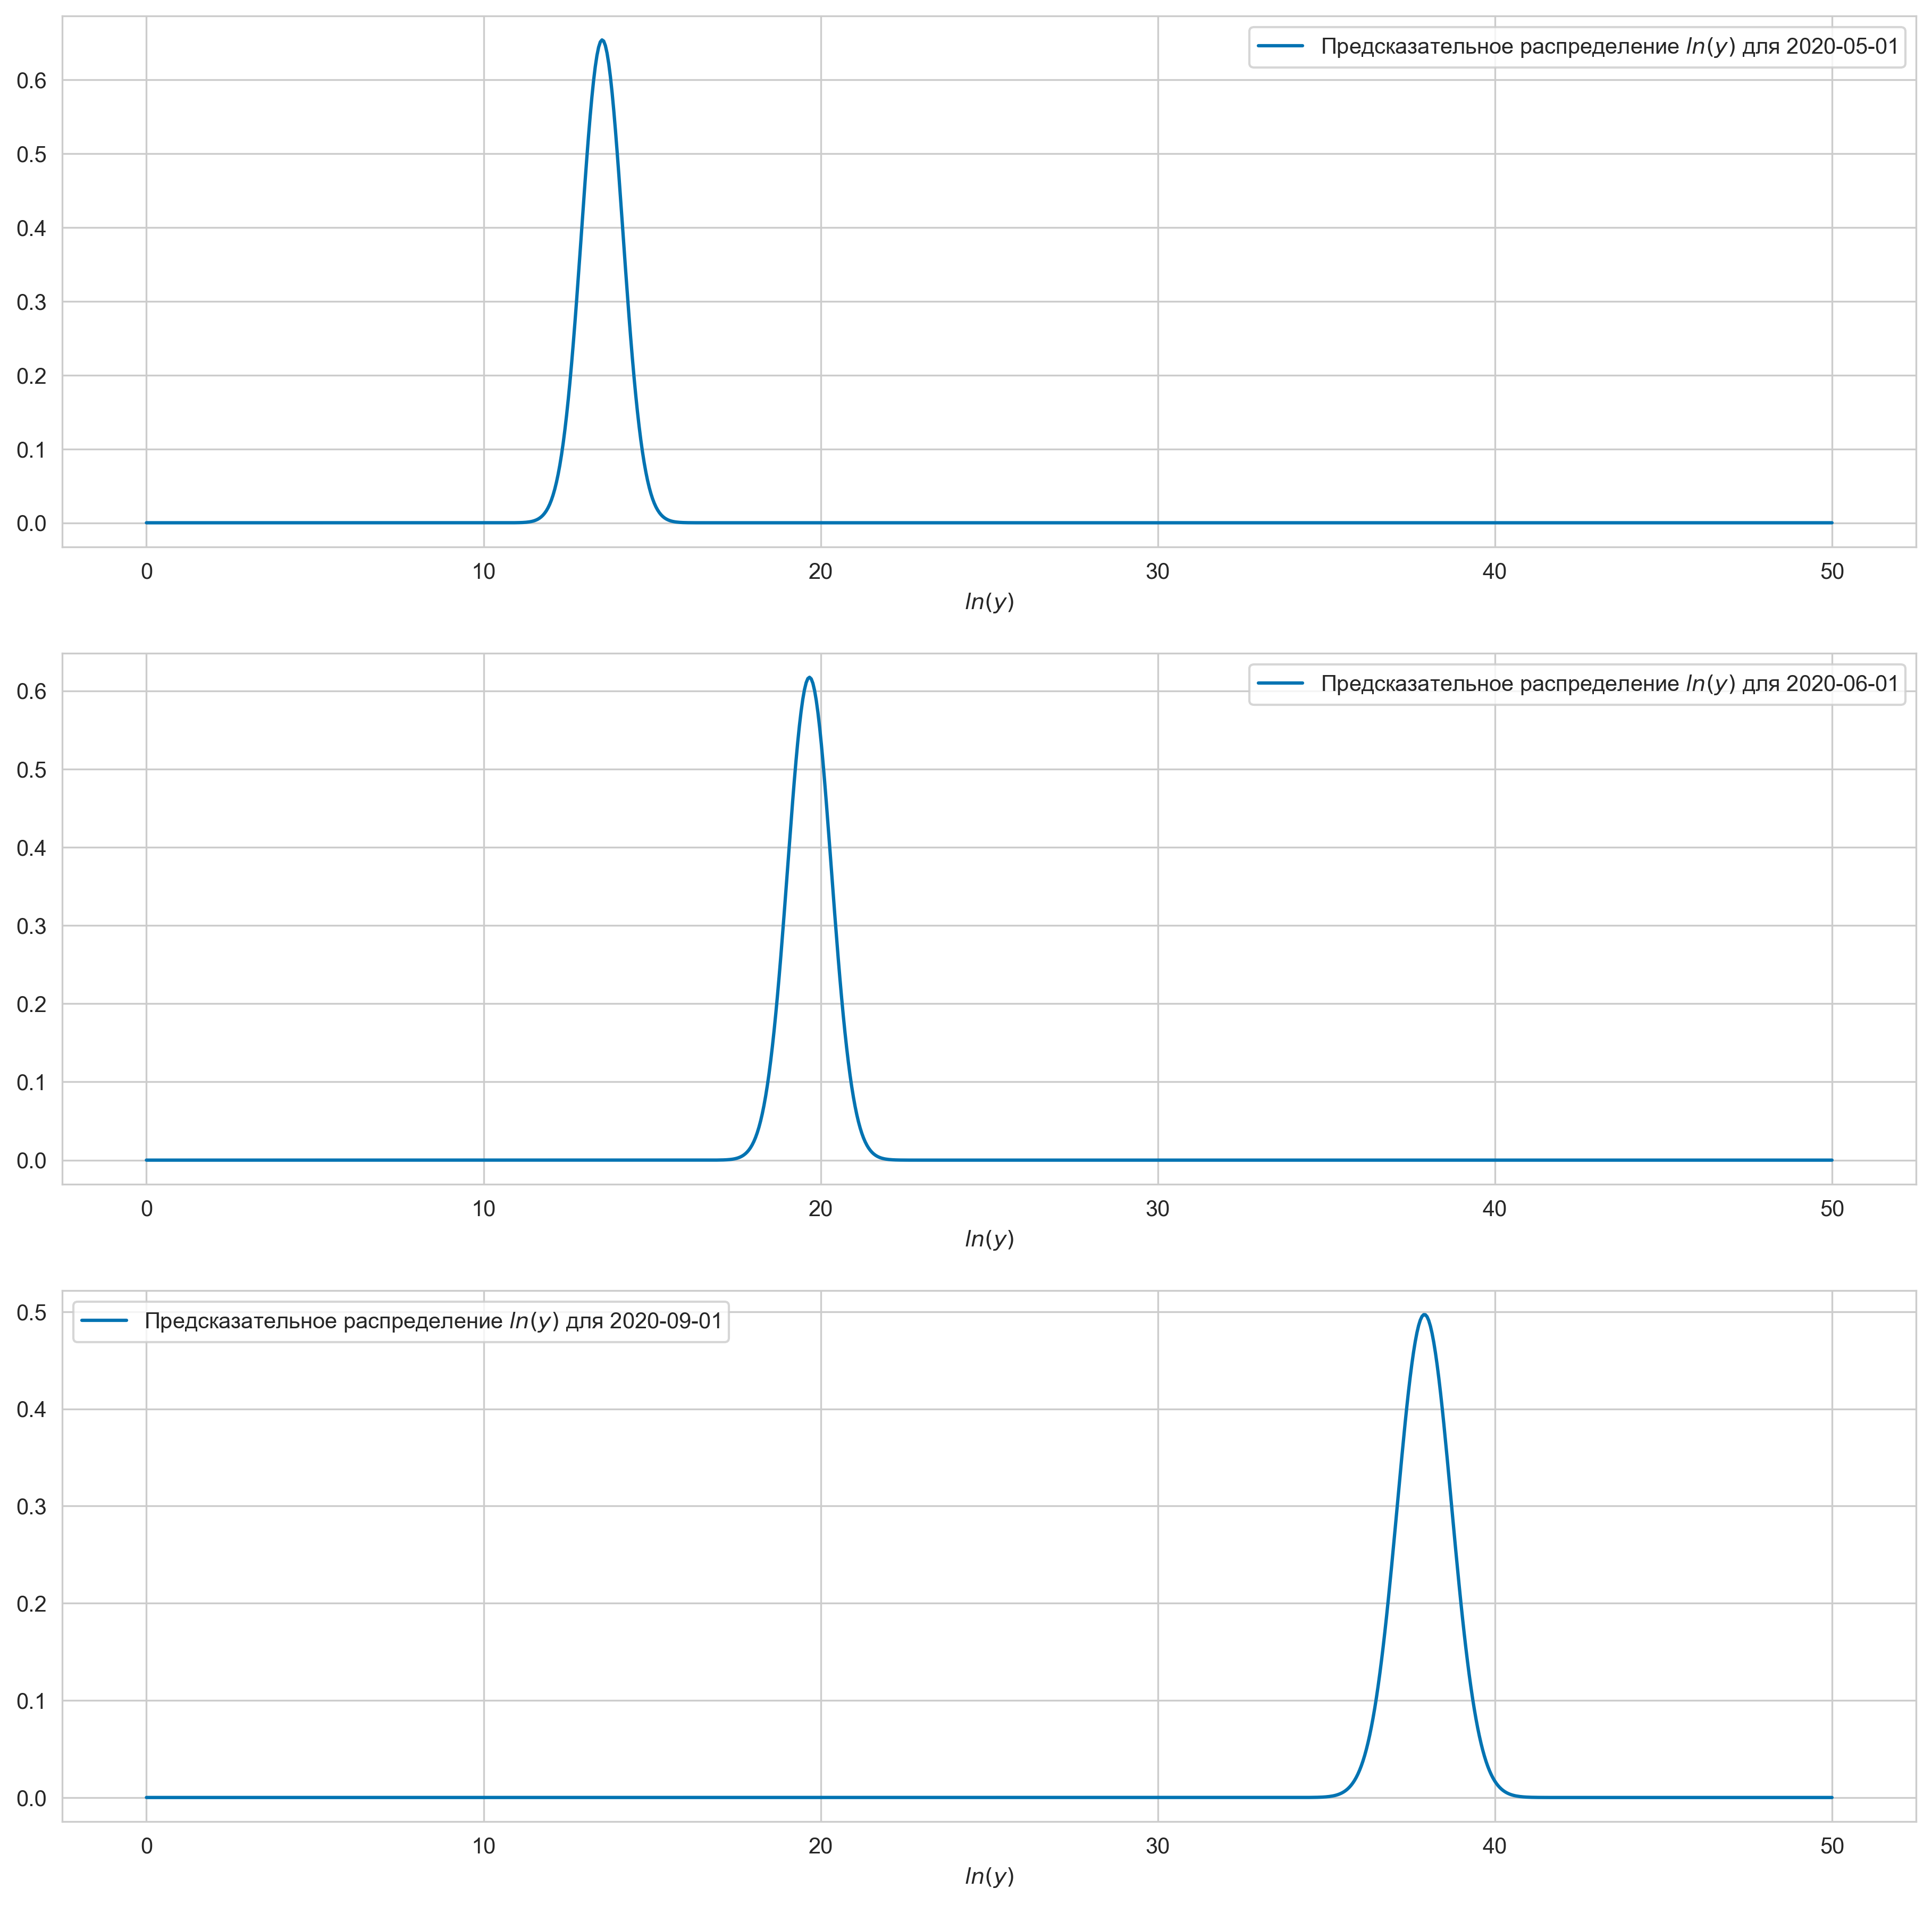

In [69]:
may_day = main_df[main_df.date == '2020-05-01'].num_day.iloc[0]
june_day = main_df[main_df.date == '2020-06-01'].num_day.iloc[0]
sept_day = main_df[main_df.date == '2020-09-01'].num_day.iloc[0]

xs = np.linspace(0, 50, 1000)

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(311)
ax1.set_xlabel('$ln(y)$')
ax1.plot(xs, multivariate_normal.pdf(xs, mean=pred_mu(may_day), cov=pred_sigma(may_day)),
        label='Предсказательное распределение $ln(y)$ для 2020-05-01')
ax1.legend()

ax2 = fig.add_subplot(312)
ax2.set_xlabel('$ln(y)$')
ax2.plot(xs, multivariate_normal.pdf(xs, mean=pred_mu(june_day), cov=pred_sigma(june_day)),
        label='Предсказательное распределение $ln(y)$ для 2020-06-01')
ax2.legend()

ax3 = fig.add_subplot(313)
ax3.set_xlabel('$ln(y)$')
ax3.plot(xs, multivariate_normal.pdf(xs, mean=pred_mu(sept_day), cov=pred_sigma(sept_day)),
        label='Предсказательное распределение $ln(y)$ для 2020-09-01')
ax3.legend()

Случайная величина $ln(y)$ распределена нормально с параметрами $\mu$ и $\sigma^2$, соотвественно,
случайная величина $y$ распределена логнормально с теми же параметрами.

In [70]:
def lognorm_pdf(x, mean=0, scale=1):
    return np.exp(-(np.log(x) - mean)**2 / (2 * scale**2)) / (x * scale * np.sqrt(2 * np.pi))

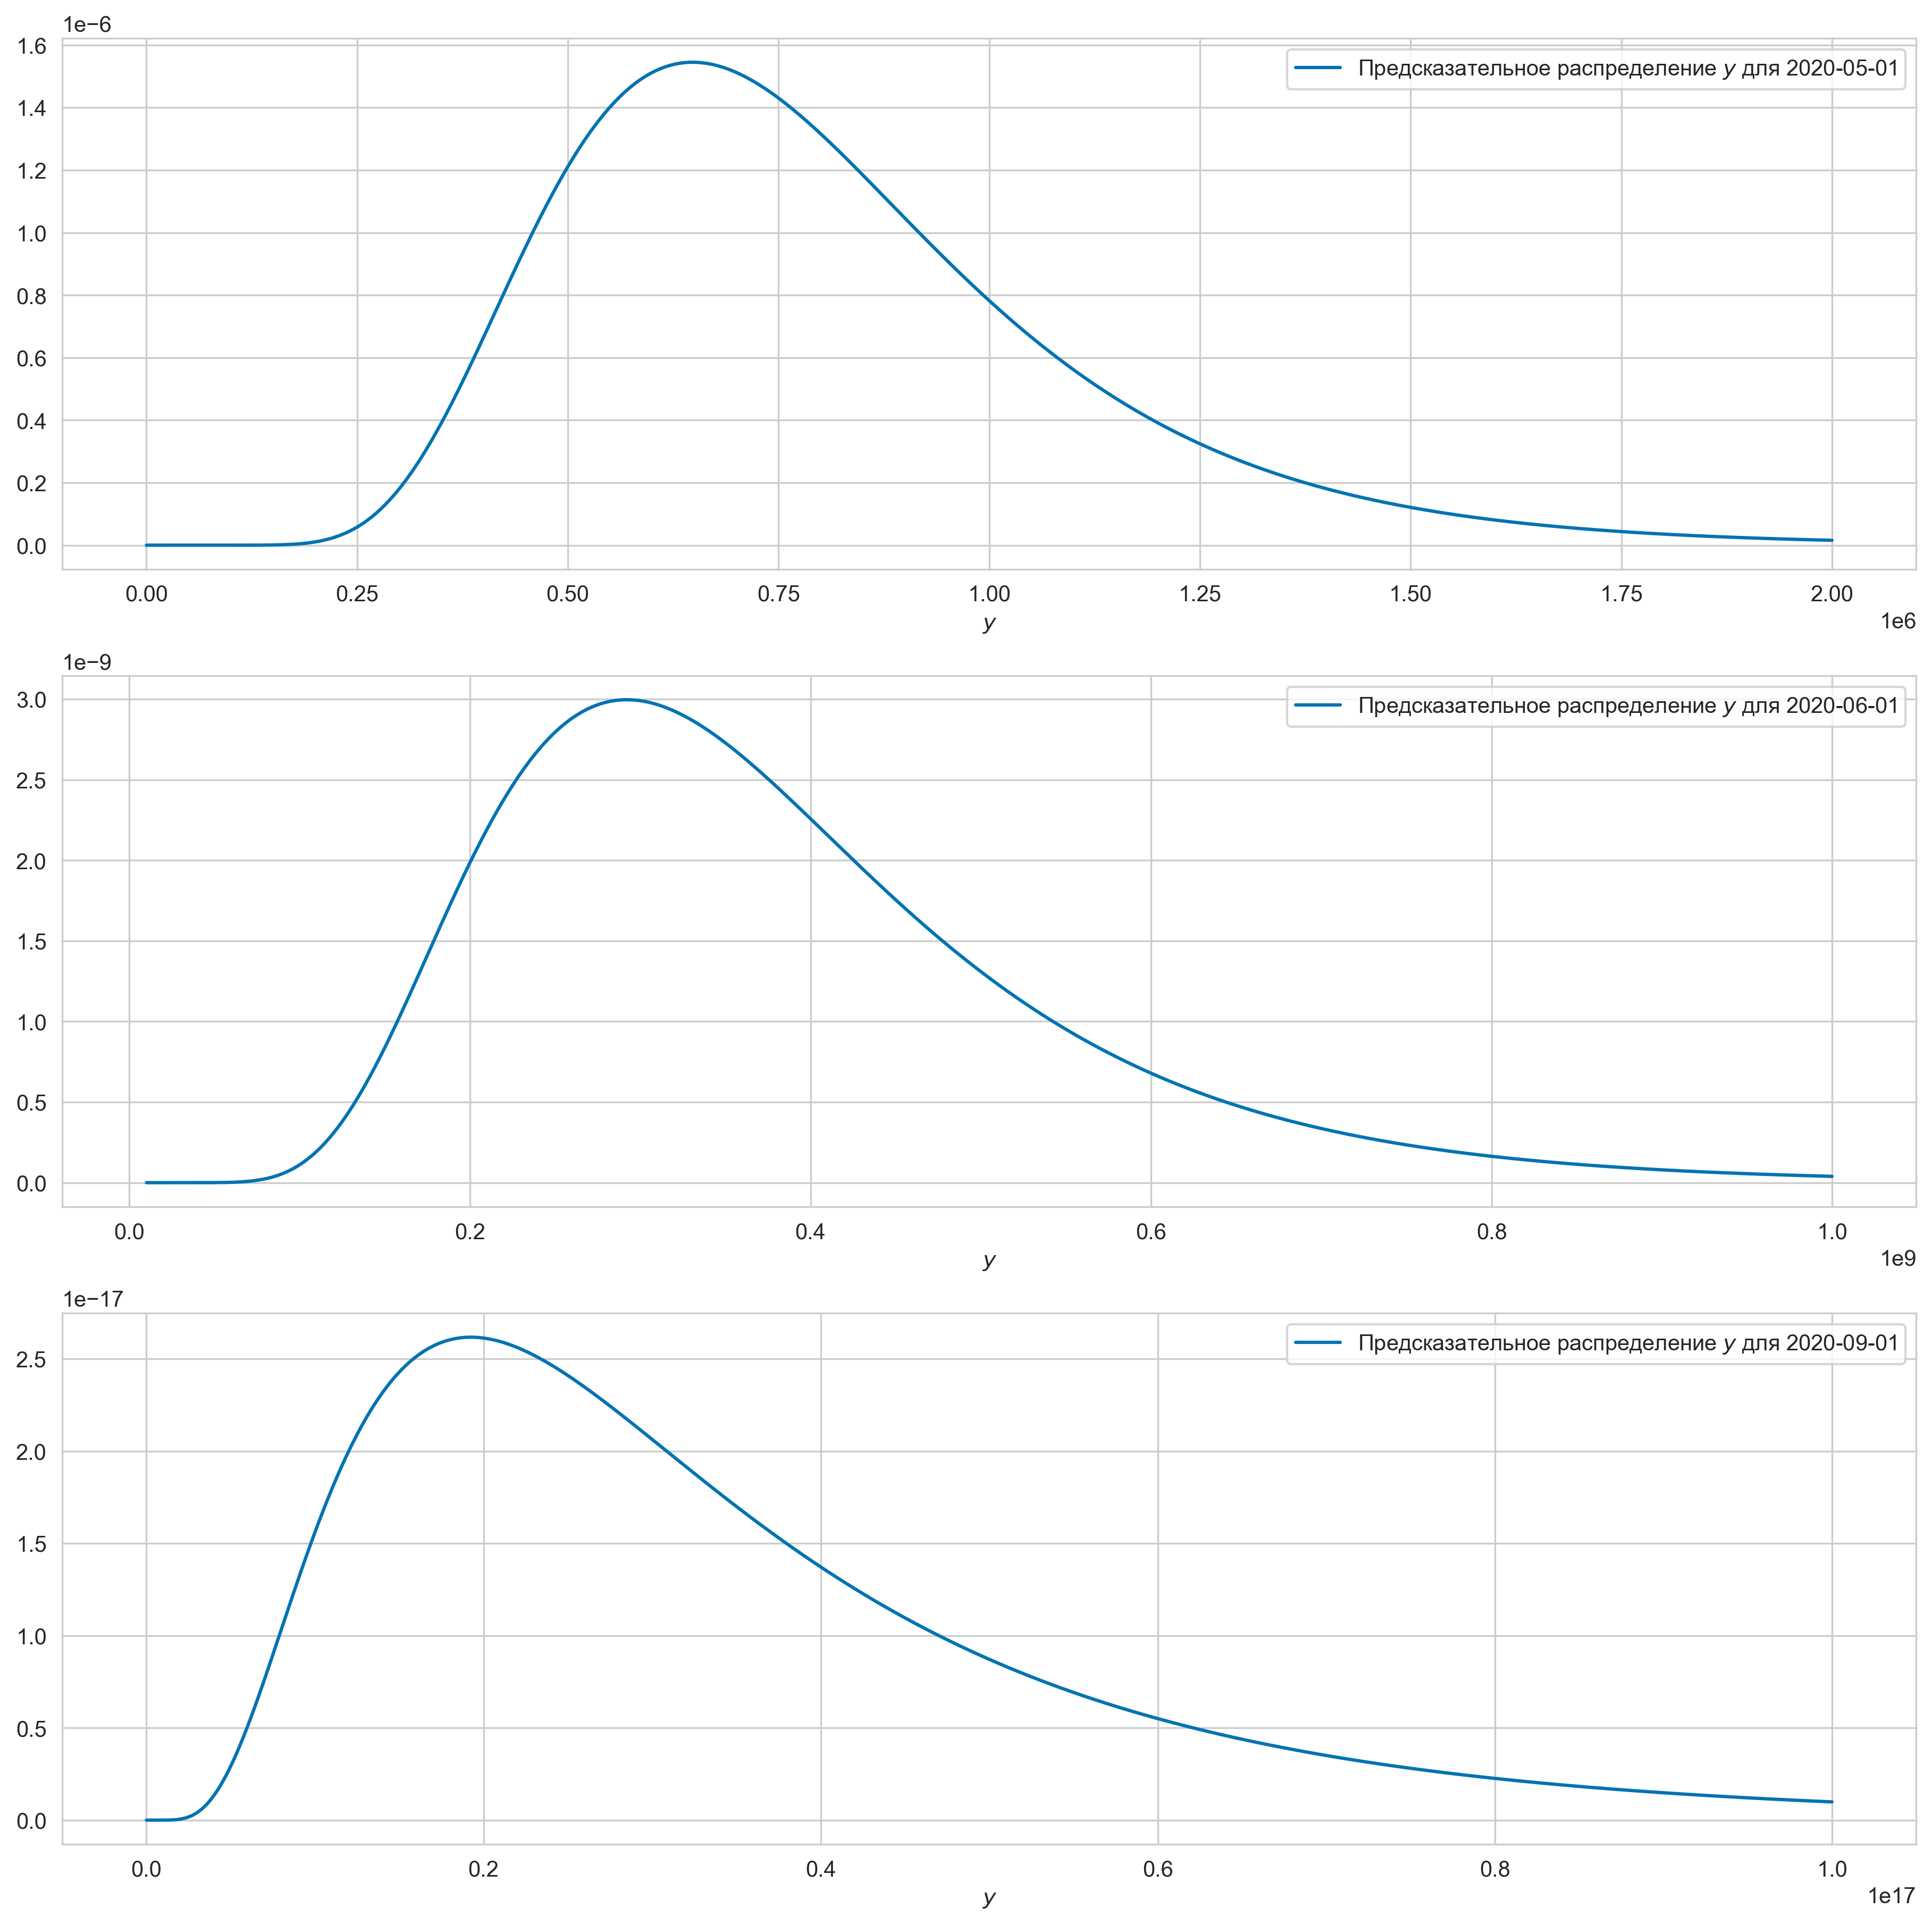

In [71]:
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(311)
ax1.plot(np.arange(1, 2e6), lognorm_pdf(np.arange(1, 2e6), mean=pred_mu(may_day), 
                                          scale=pred_sigma(may_day)),
        label='Предсказательное распределение $y$ для 2020-05-01')
ax1.set_xlabel('$y$')
ax1.legend()

ax2 = fig.add_subplot(312)
ax2.plot(np.arange(10e6, 1e9, 1e5), lognorm_pdf(np.arange(10e6, 1e9, 1e5), mean=pred_mu(june_day), 
                                          scale=pred_sigma(june_day)),
        label='Предсказательное распределение $y$ для 2020-06-01')
ax2.set_xlabel('$y$')
ax2.legend()

ax3 = fig.add_subplot(313)
ax3.plot(np.arange(10e8, 1e17, 1e13), lognorm_pdf(np.arange(10e8, 1e17, 1e13), mean=pred_mu(sept_day), 
                                          scale=pred_sigma(sept_day)),
        label='Предсказательное распределение $y$ для 2020-09-01')
ax3.set_xlabel('$y$')
ax3.legend()

МАР гипотеза и интервалы дисперсий шума данных и предсказаний для 100 точек, исходя из данных сэмплирования

In [72]:
def emperical_plot_predictions(xs, noise, mu, x):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((-2, 25))
    ax.plot(xs, mu[1]*xs + mu[0], color="red", label="MAP гипотеза")
    ax.fill_between(xs, mu[1]*xs + mu[0] - noise, mu[1]*xs + mu[0] + noise, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(train.num_day.values, np.log(train.total_cases.values), marker='*', s=200, label='Train set')
    ax.plot(test.num_day.values, np.log(test.total_cases.values), c='g', label='Правильный ответ')
    ax.set_xlabel('Номер дня')
    ax.set_ylabel('$ln(y)$')
    ax.legend(fontsize=legend_fontsize)

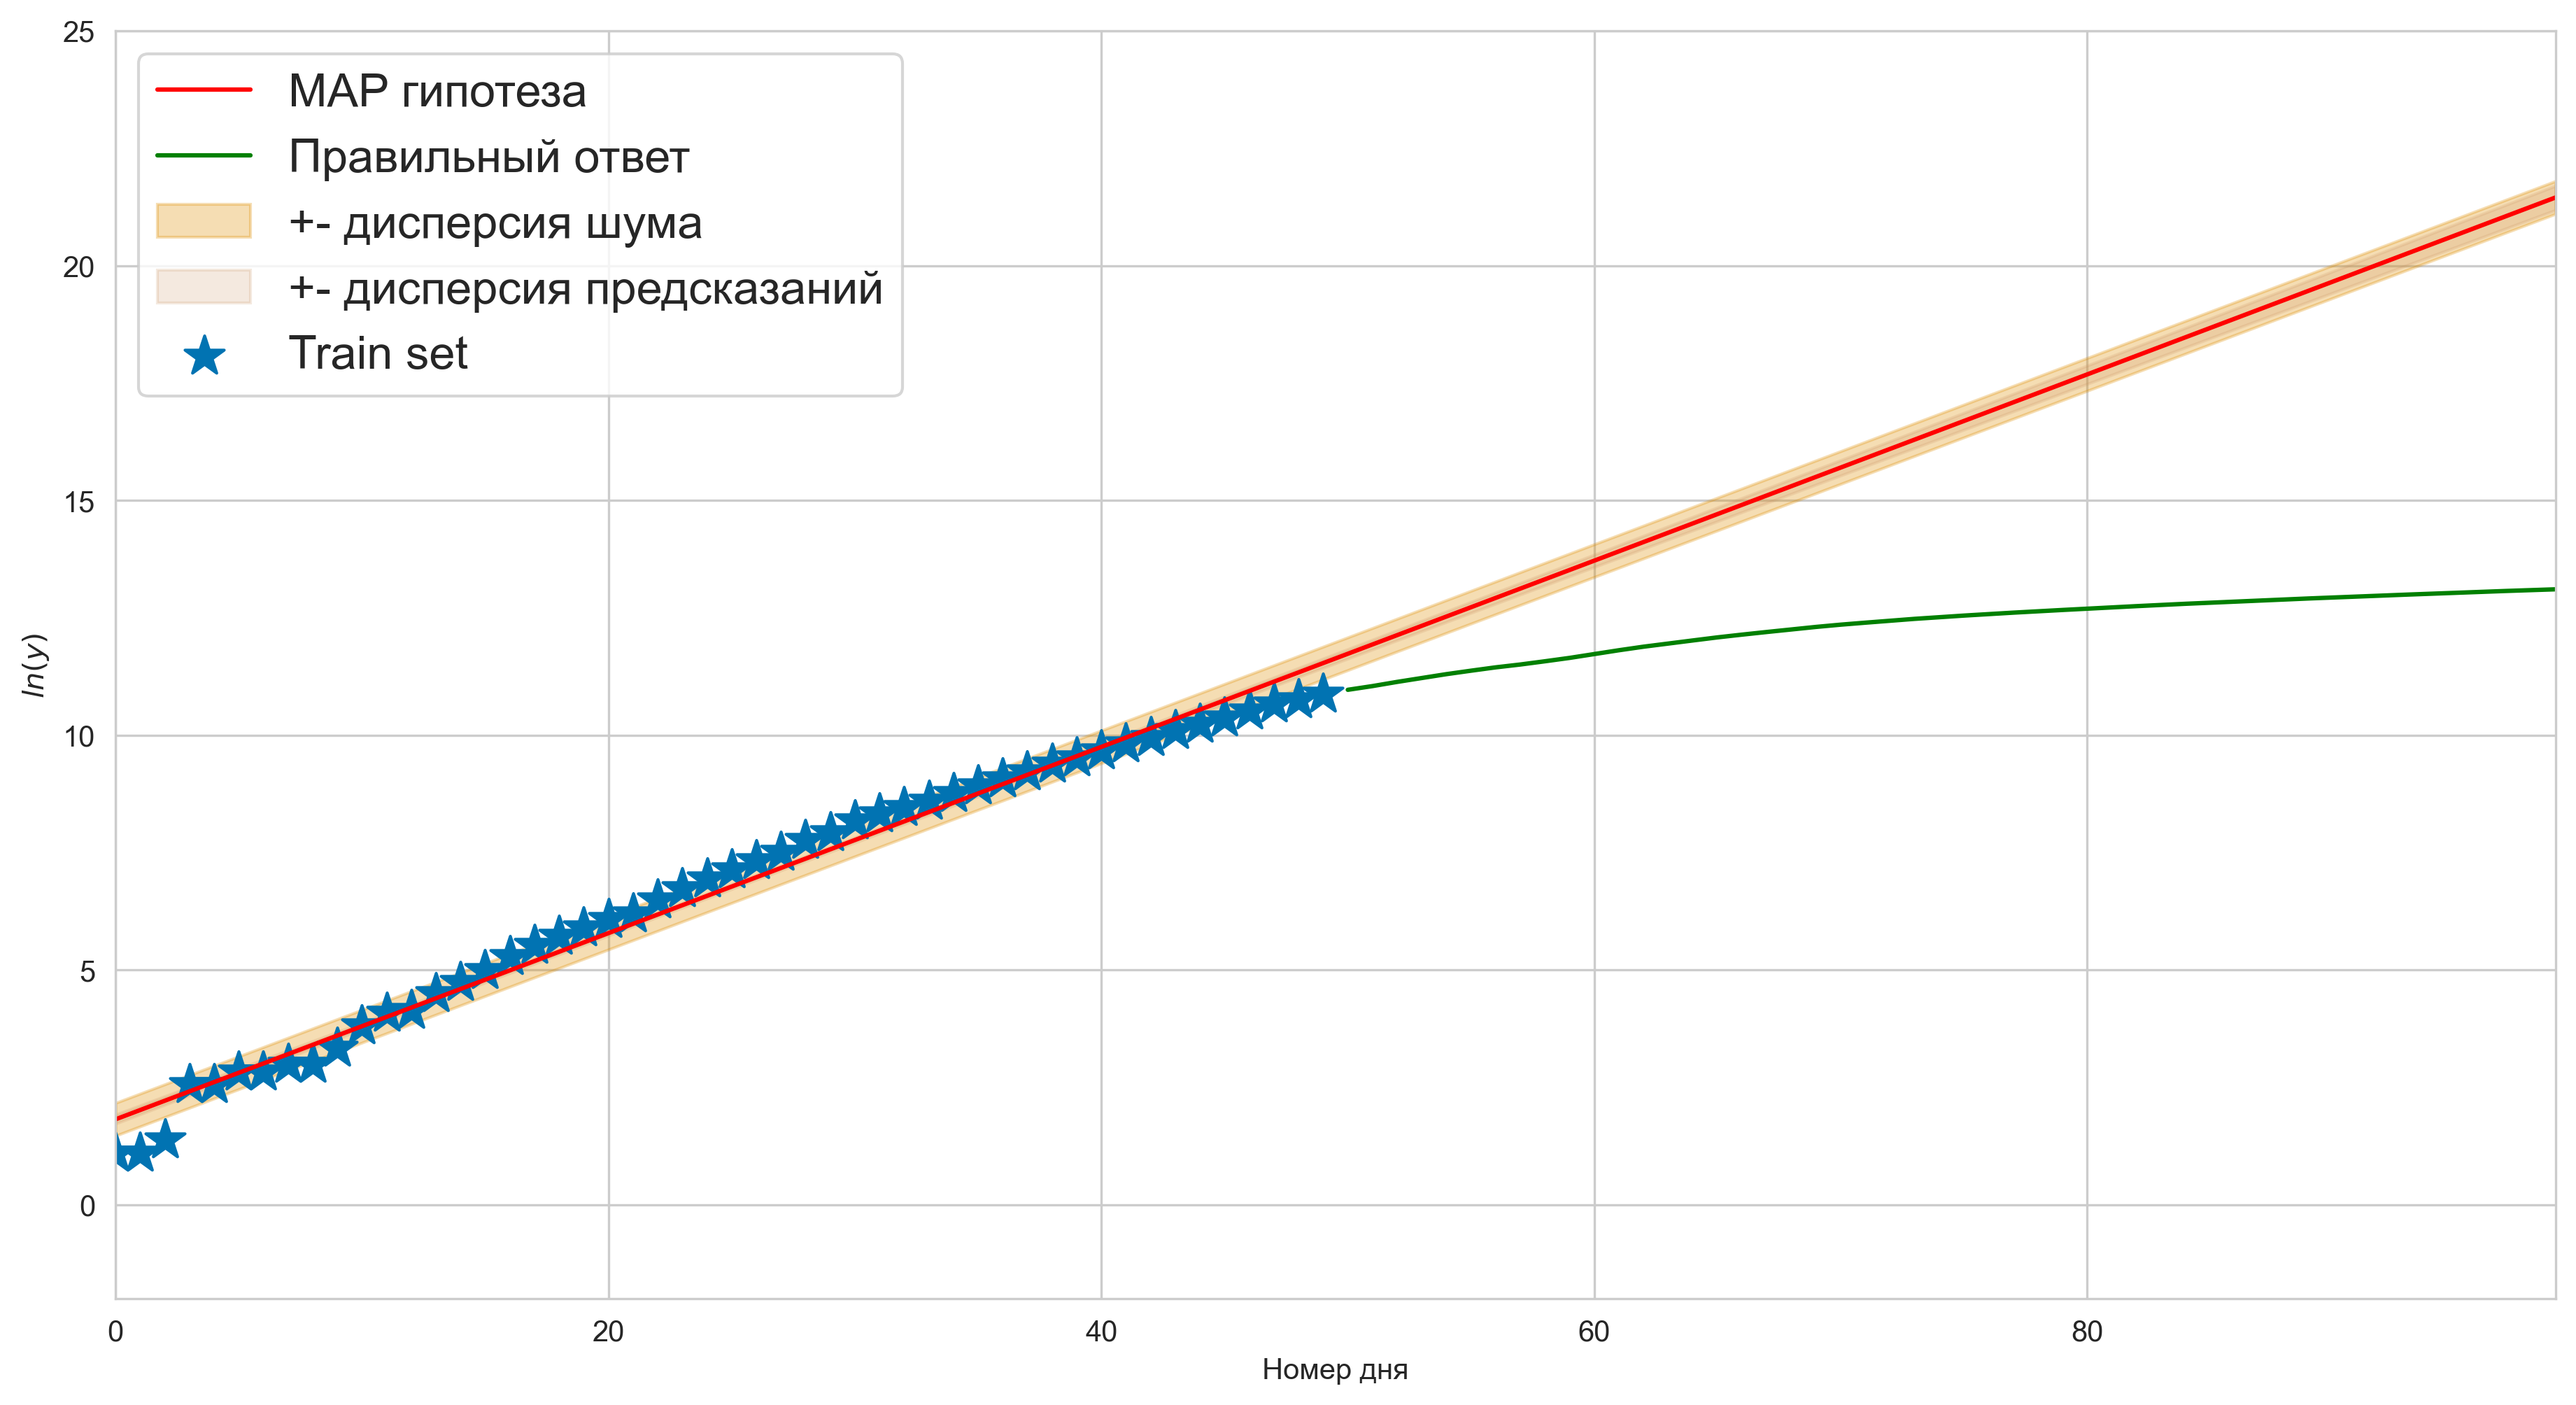

In [73]:
emperical_plot_predictions(np.arange(100), sigma_noise, cur_mu, x)

МАР гипотеза и интервалы дисперсий шума данных и предсказаний для 100 точек, исходя из параметров гауссиана 
предсказательного распределения для каждой точки

In [74]:
def plot_predictions(xs, noise):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((-2, 20))
    ax.plot(xs, pred_mu(xs), color="red", label="MAP гипотеза")
    ax.fill_between(xs, pred_mu(xs) - noise, pred_mu(xs) + noise, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, pred_mu(xs) - pred_sigma(xs), pred_mu(xs) + pred_sigma(xs), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(train.num_day.values, np.log(train.total_cases.values), marker='*', s=200, label='Train set')
    ax.plot(test.num_day.values, np.log(test.total_cases.values), c='g', label='Правильный ответ')
    ax.set_xlabel('Номер дня')
    ax.set_ylabel('$ln(y)$')
    ax.legend(fontsize=legend_fontsize)

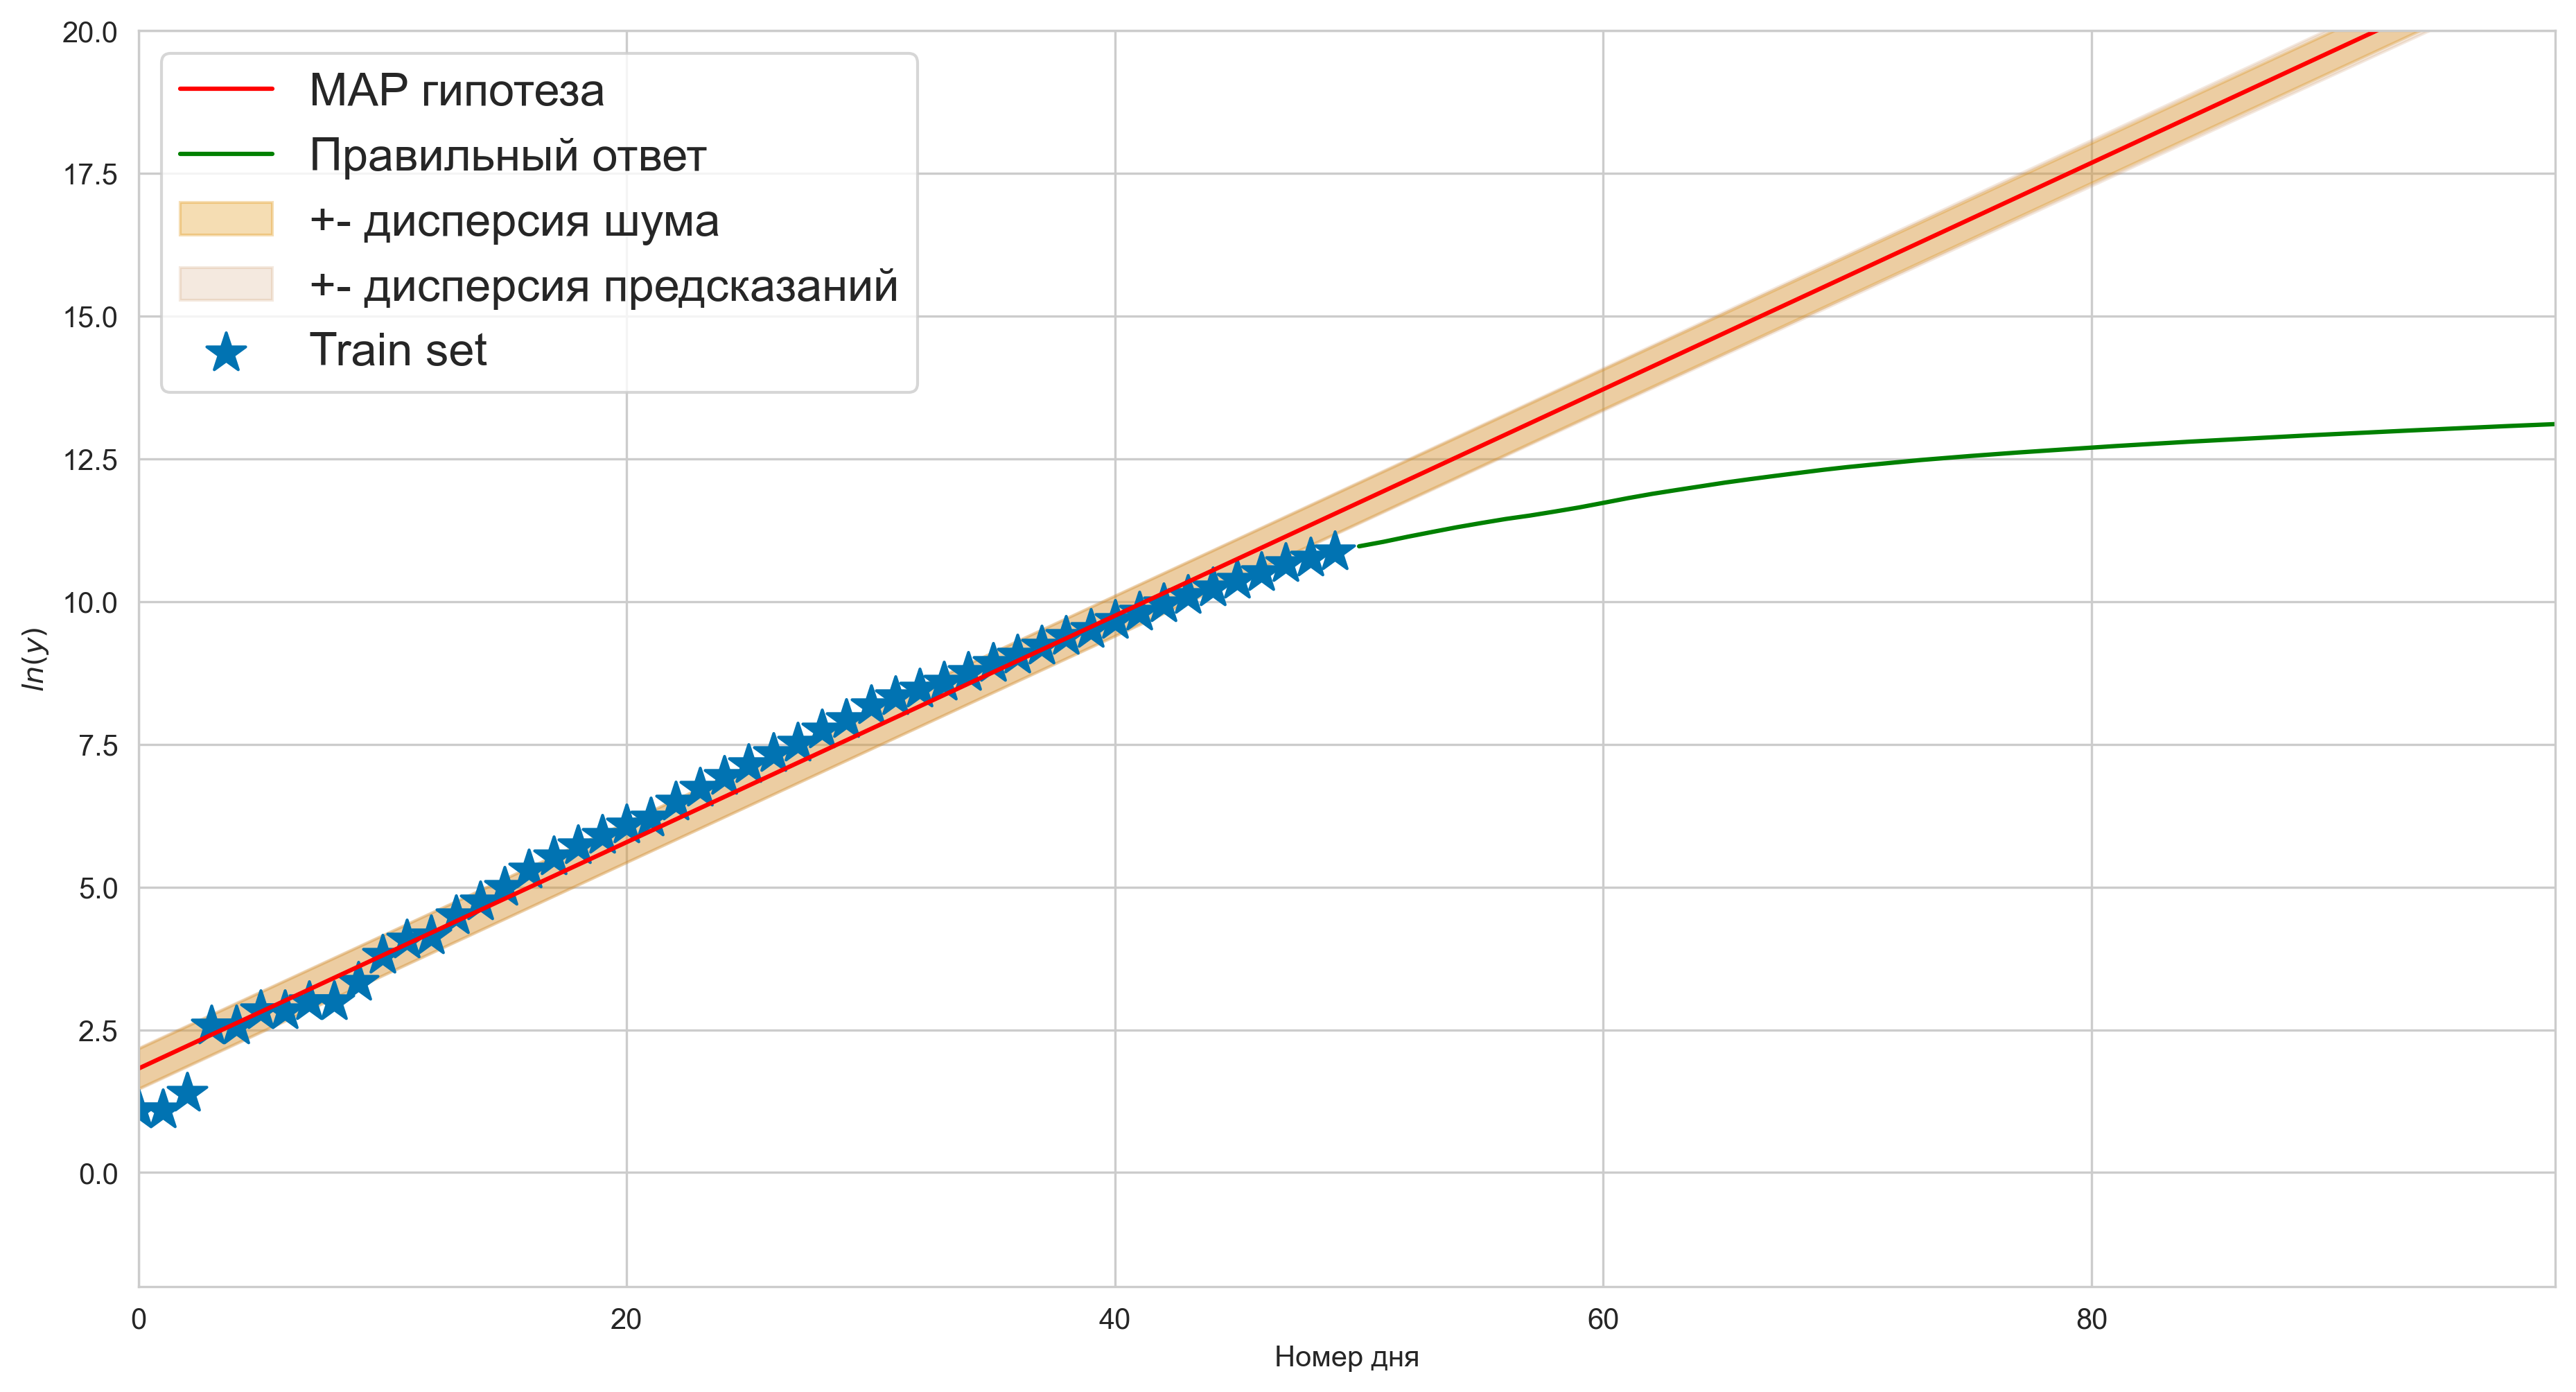

In [75]:
plot_predictions(np.arange(100), sigma_noise)

Графики на основе эмпирических данных и на основе параметров гауссиана предсказательного распределения 
получились идентичными.

## Сигмоидальная модель

Рассмотрим сигмоидальную модель вида:
$$y \sim \int_{-\infty}^x e^{\bar{w}^T\bar{t}}\,\mathrm{d}t.$$
Сведем обучение этой модели к обучению модели линейной регрессии:
$$ln(y') \sim \bar{w}^T\bar{x}$$
где $y$ - total cases;\
$y'$ - new cases;\
$x$ - номер дня.\
Для получения значений *total cases* по предсказаниям линейной регрессии необходимо взять экспоненту 
и кумулятивную сумму от ответов модели.

Коэффициенты модели линейной регрессии: (0.2756228319027641, -0.0018297906166869166, -0.39659040284162383)


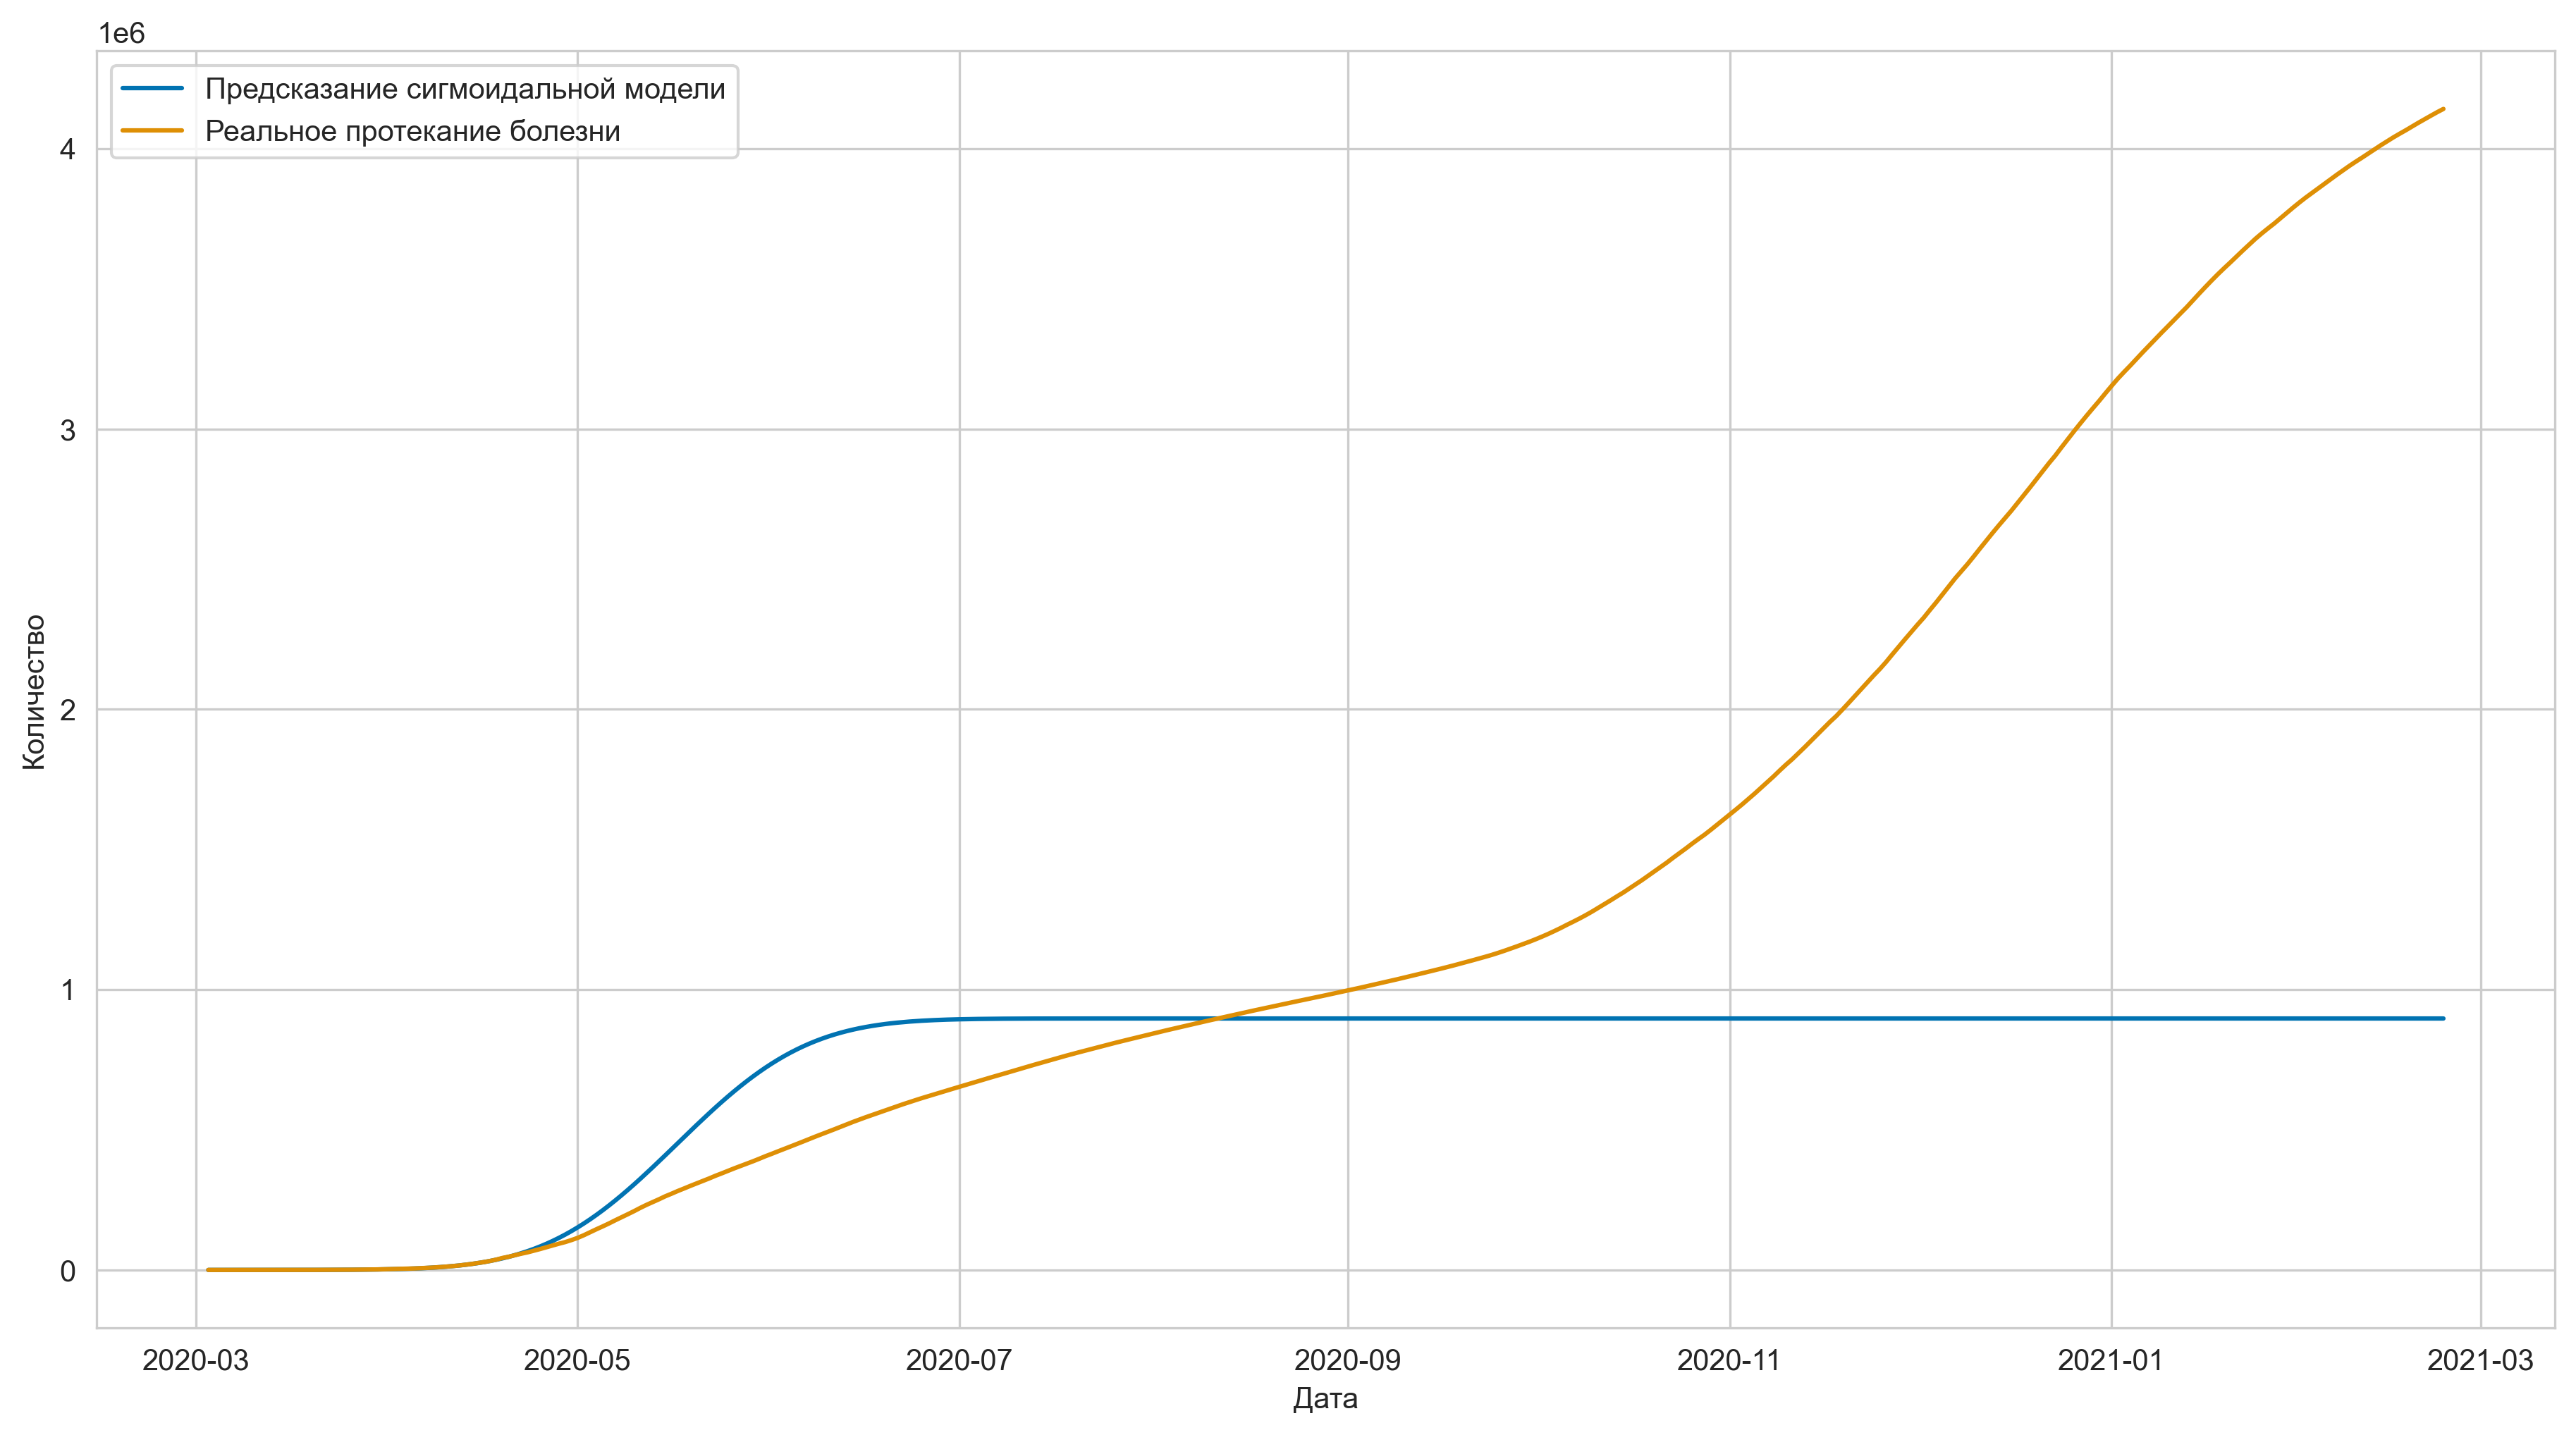

In [76]:
model=LinearRegression()
model.fit(train[['num_day', 'num_days_squared']], np.log(train.new_cases.values))
print(f'Коэффициенты модели линейной регрессии: {(*model.coef_, model.intercept_)}')

plt.plot(main_df.date.values, np.cumsum(np.exp(model.predict(main_df[['num_day', 'num_days_squared']]))), 
         label='Предсказание сигмоидальной модели')
plt.plot(main_df.date.values, main_df.total_cases.values, label='Реальное протекание болезни')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.legend()

## 3b

In [77]:
preds = model.predict(train[['num_day', 'num_days_squared']])
sigma_noise = np.sqrt(np.sum((preds - np.log(train.new_cases.values)) ** 2) / len(train))
print('Среднеквадратическое отклонение шума в данных %.4f' % sigma_noise)

Среднеквадратическое отклонение шума в данных 0.4892


In [78]:
# Мат. ожидание и ковариационная матрица априорного распредления
cur_mu, cur_sigma = np.array([0, 0, 0]), np.diag([100, 100, 100])

In [79]:
def bayesian_update(mu, sigma, x, y, sigma_noise=sigma_noise):
#     Шаг байесовского вывода
    x_matrix = np.array([[1., x, x ** 2]])
    sigma_n = np.linalg.inv(np.linalg.inv(sigma)+ (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), x_matrix) )
    mu_n = np.matmul(sigma_n, np.matmul(np.linalg.inv(sigma), np.transpose(mu)) + (1 / (sigma_noise ** 2)) * np.matmul(np.transpose(x_matrix), np.array([y]) ) )
    return mu_n, sigma_n

In [80]:
# Получение апостериорного распределения
x_list, y_list = train.num_day.values, np.log(train.new_cases.values)

for i in range(len(train)):
    cur_mu, cur_sigma = bayesian_update(cur_mu, cur_sigma, x_list[i], y_list[i])

In [81]:
print('Параметры модели линейной регрессии: (%.4f, %.4f, %.4f)' % (model.intercept_, *model.coef_))
print('Мат. ожидание апостериорного распределения параметров: (%.4f, %.4f, %.4f)' % tuple(cur_mu))
print(f'Ковариационная матрица апостериорного распределения:\n {cur_sigma}')

Параметры модели линейной регрессии: (-0.3966, 0.2756, -0.0018)
Мат. ожидание апостериорного распределения параметров: (-0.3964, 0.2756, -0.0018)
Ковариационная матрица апостериорного распределения:
 [[ 3.97858000e-02 -3.21446447e-03  5.41155378e-05]
 [-3.21446447e-03  3.54467031e-04 -6.76539758e-06]
 [ 5.41155378e-05 -6.76539758e-06  1.38075588e-07]]


## 3c

In [82]:
def sample_lines(df, mu, sigma, xs, n=20):
    my_w = np.random.multivariate_normal(mu, sigma, n)
    res = np.zeros((n, xs.shape[0]))
    total = []
    
    for i, w in enumerate(my_w):
        res[i,:] = w[0] + w[1] * xs + w[2] * xs**2
        sig_model = np.cumsum(np.exp(w[0] + w[1] * df.num_day.values + w[2] * df.num_day.values**2))
        total.append(sig_model[-1])
        plt.plot(df.num_day.values, sig_model, 'k-', lw=.4)
        plt.xlabel('Номер дня')
        plt.ylabel('Количество заболевших')
        plt.title('Графики количества заболевших, предсказанного моделями с сэмплированными параметрами')
                           
    return res, np.array(total)

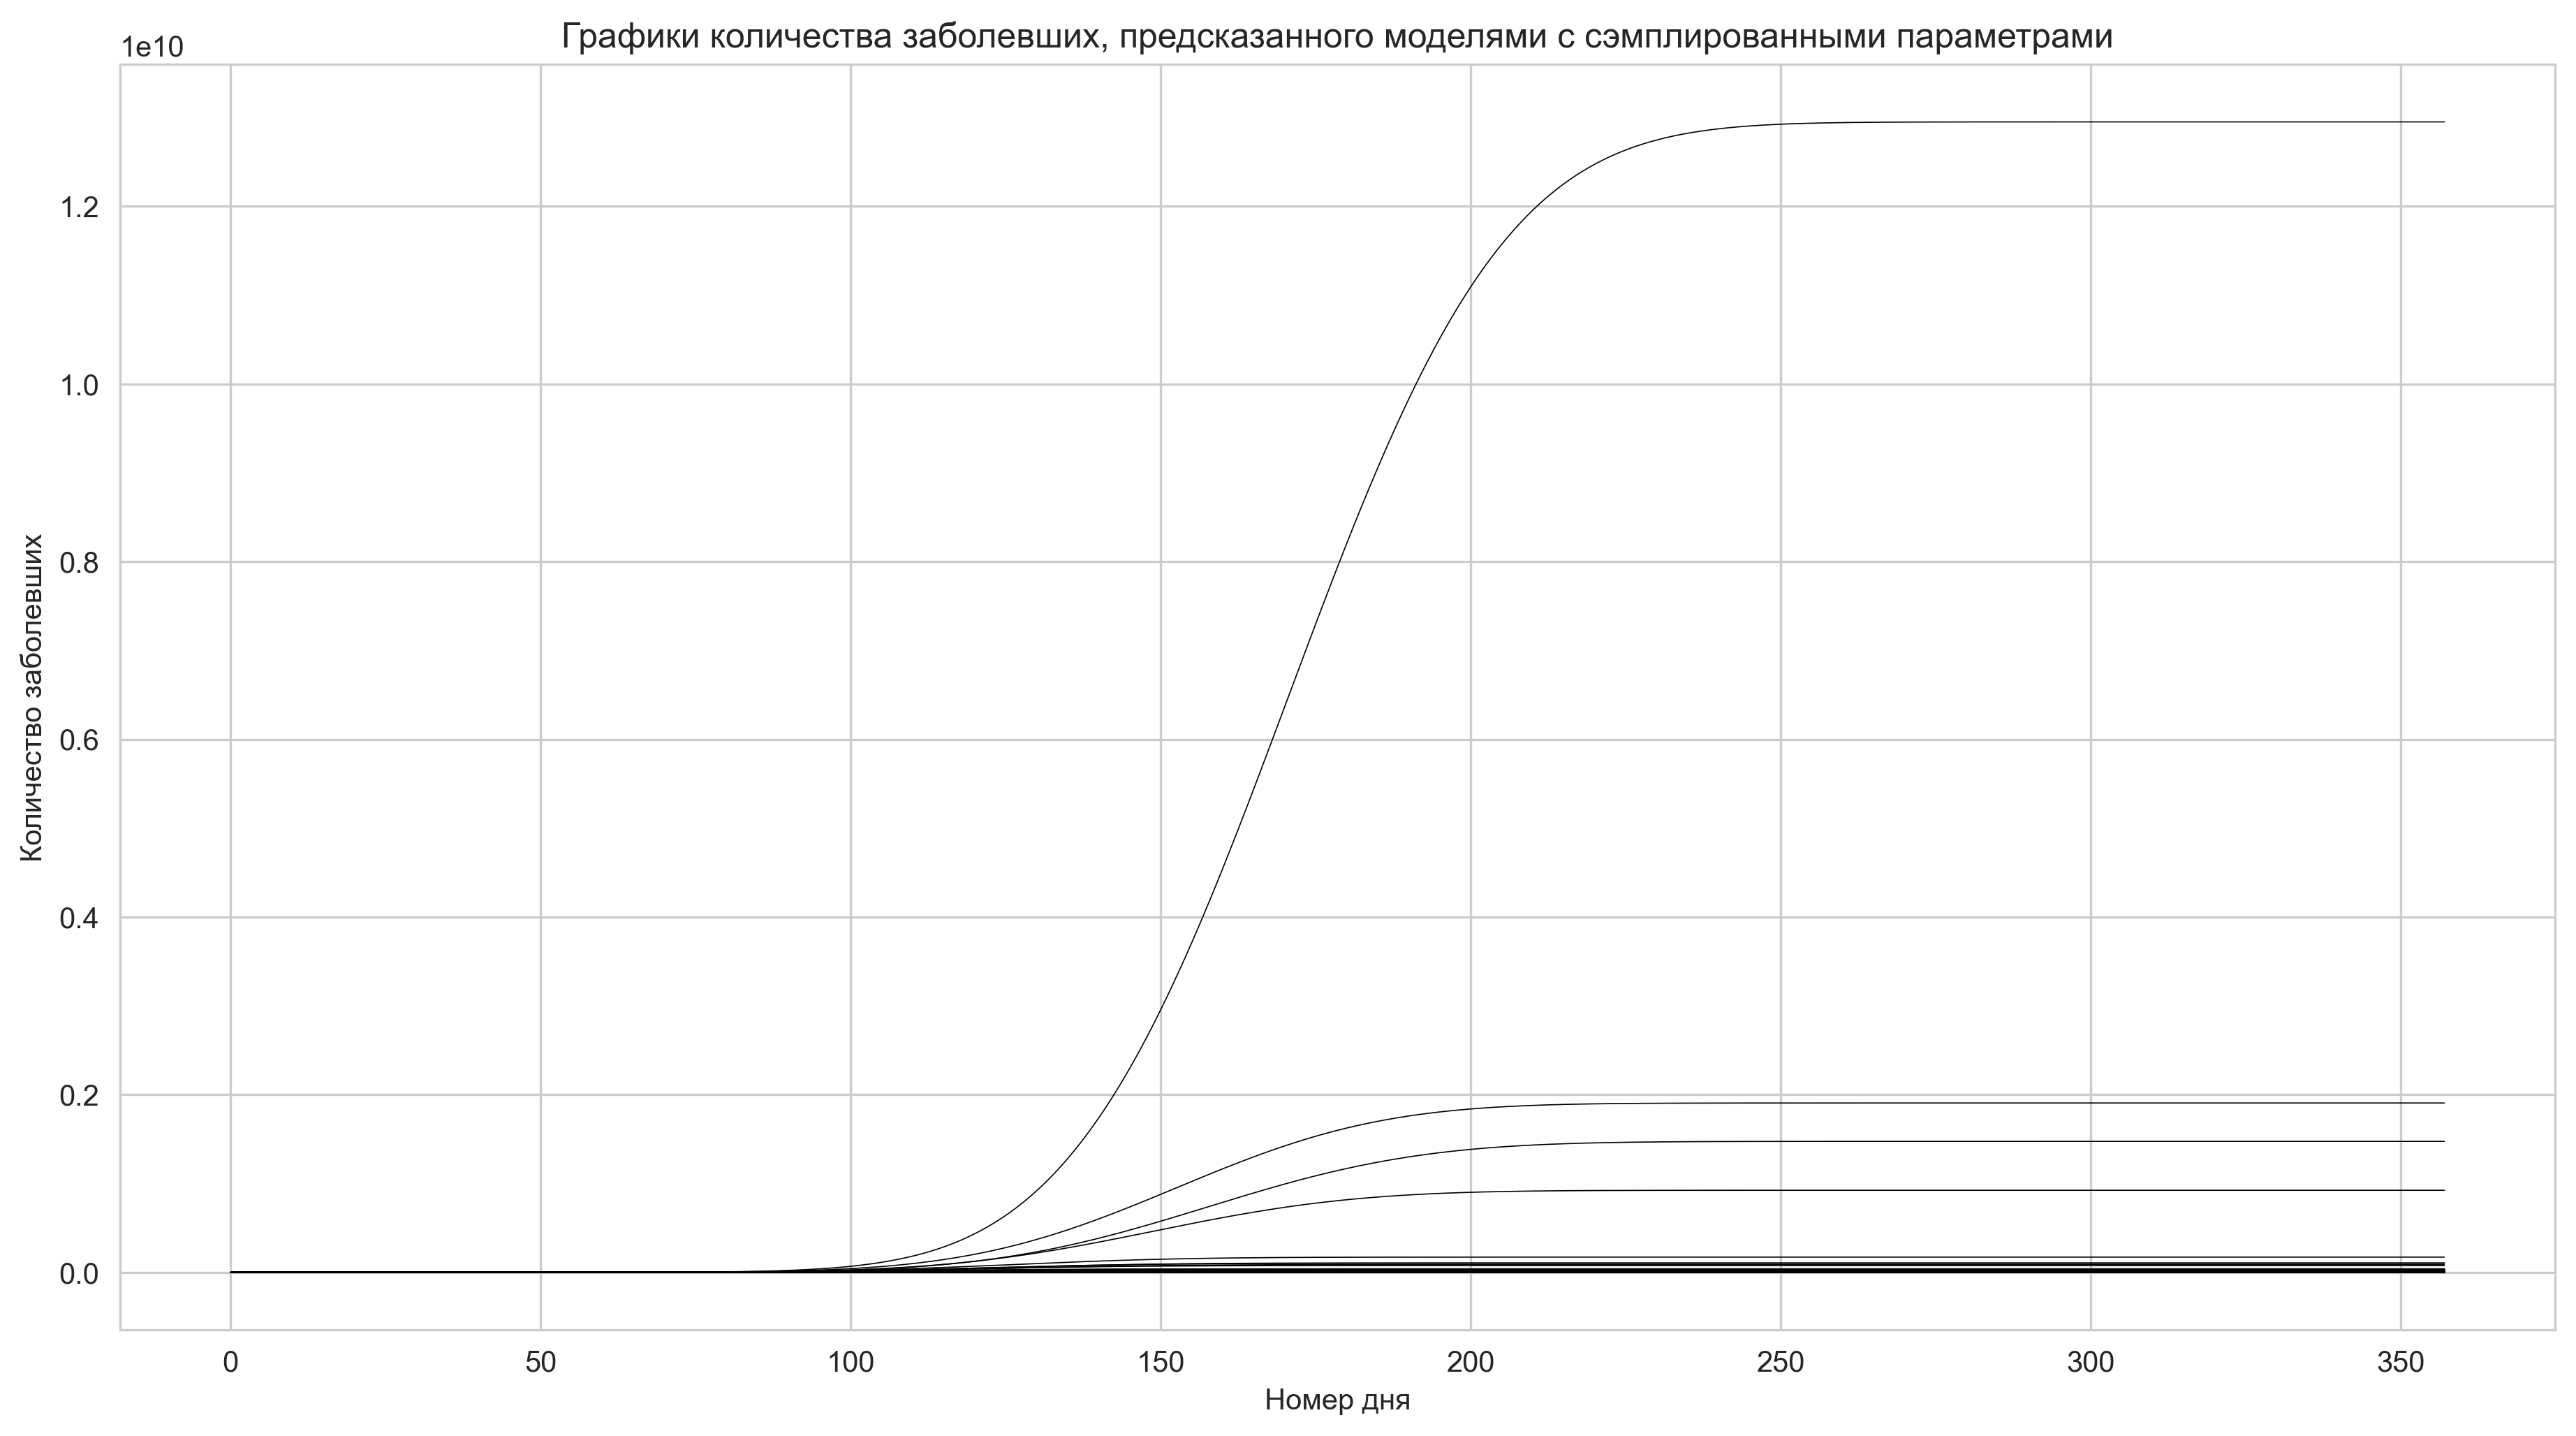

In [83]:
x, total = sample_lines(main_df, cur_mu, cur_sigma, np.arange(200), n=1000)

МАР гипотеза и интервалы дисперсий шума данных и предсказаний для 200 точек, исходя из данных сэмплирования

In [84]:
def emperical_plot_predictions(xs, noise, mu, x):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((-2, 25))
    ax.plot(xs, mu[2]*xs**2 + mu[1]*xs + mu[0], color="red", label="MAP гипотеза")
    ax.fill_between(xs, mu[2]*xs**2 + mu[1]*xs + mu[0] - noise, 
                    mu[2]*xs**2 + mu[1]*xs + mu[0] + noise, color=palette[1], 
                    alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, np.mean(x, axis=0) - np.std(x, axis=0), np.mean(x, axis=0) + np.std(x, axis=0), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(train.num_day.values, np.log(train.new_cases.values), marker='*', s=200)
    ax.plot(test.num_day.values, np.log(test.new_cases.values), c='g', label='Правильный ответ')
    ax.set_xlabel('Номер дня')
    ax.set_ylabel('$ln(y\')$')
    ax.legend(fontsize=legend_fontsize)

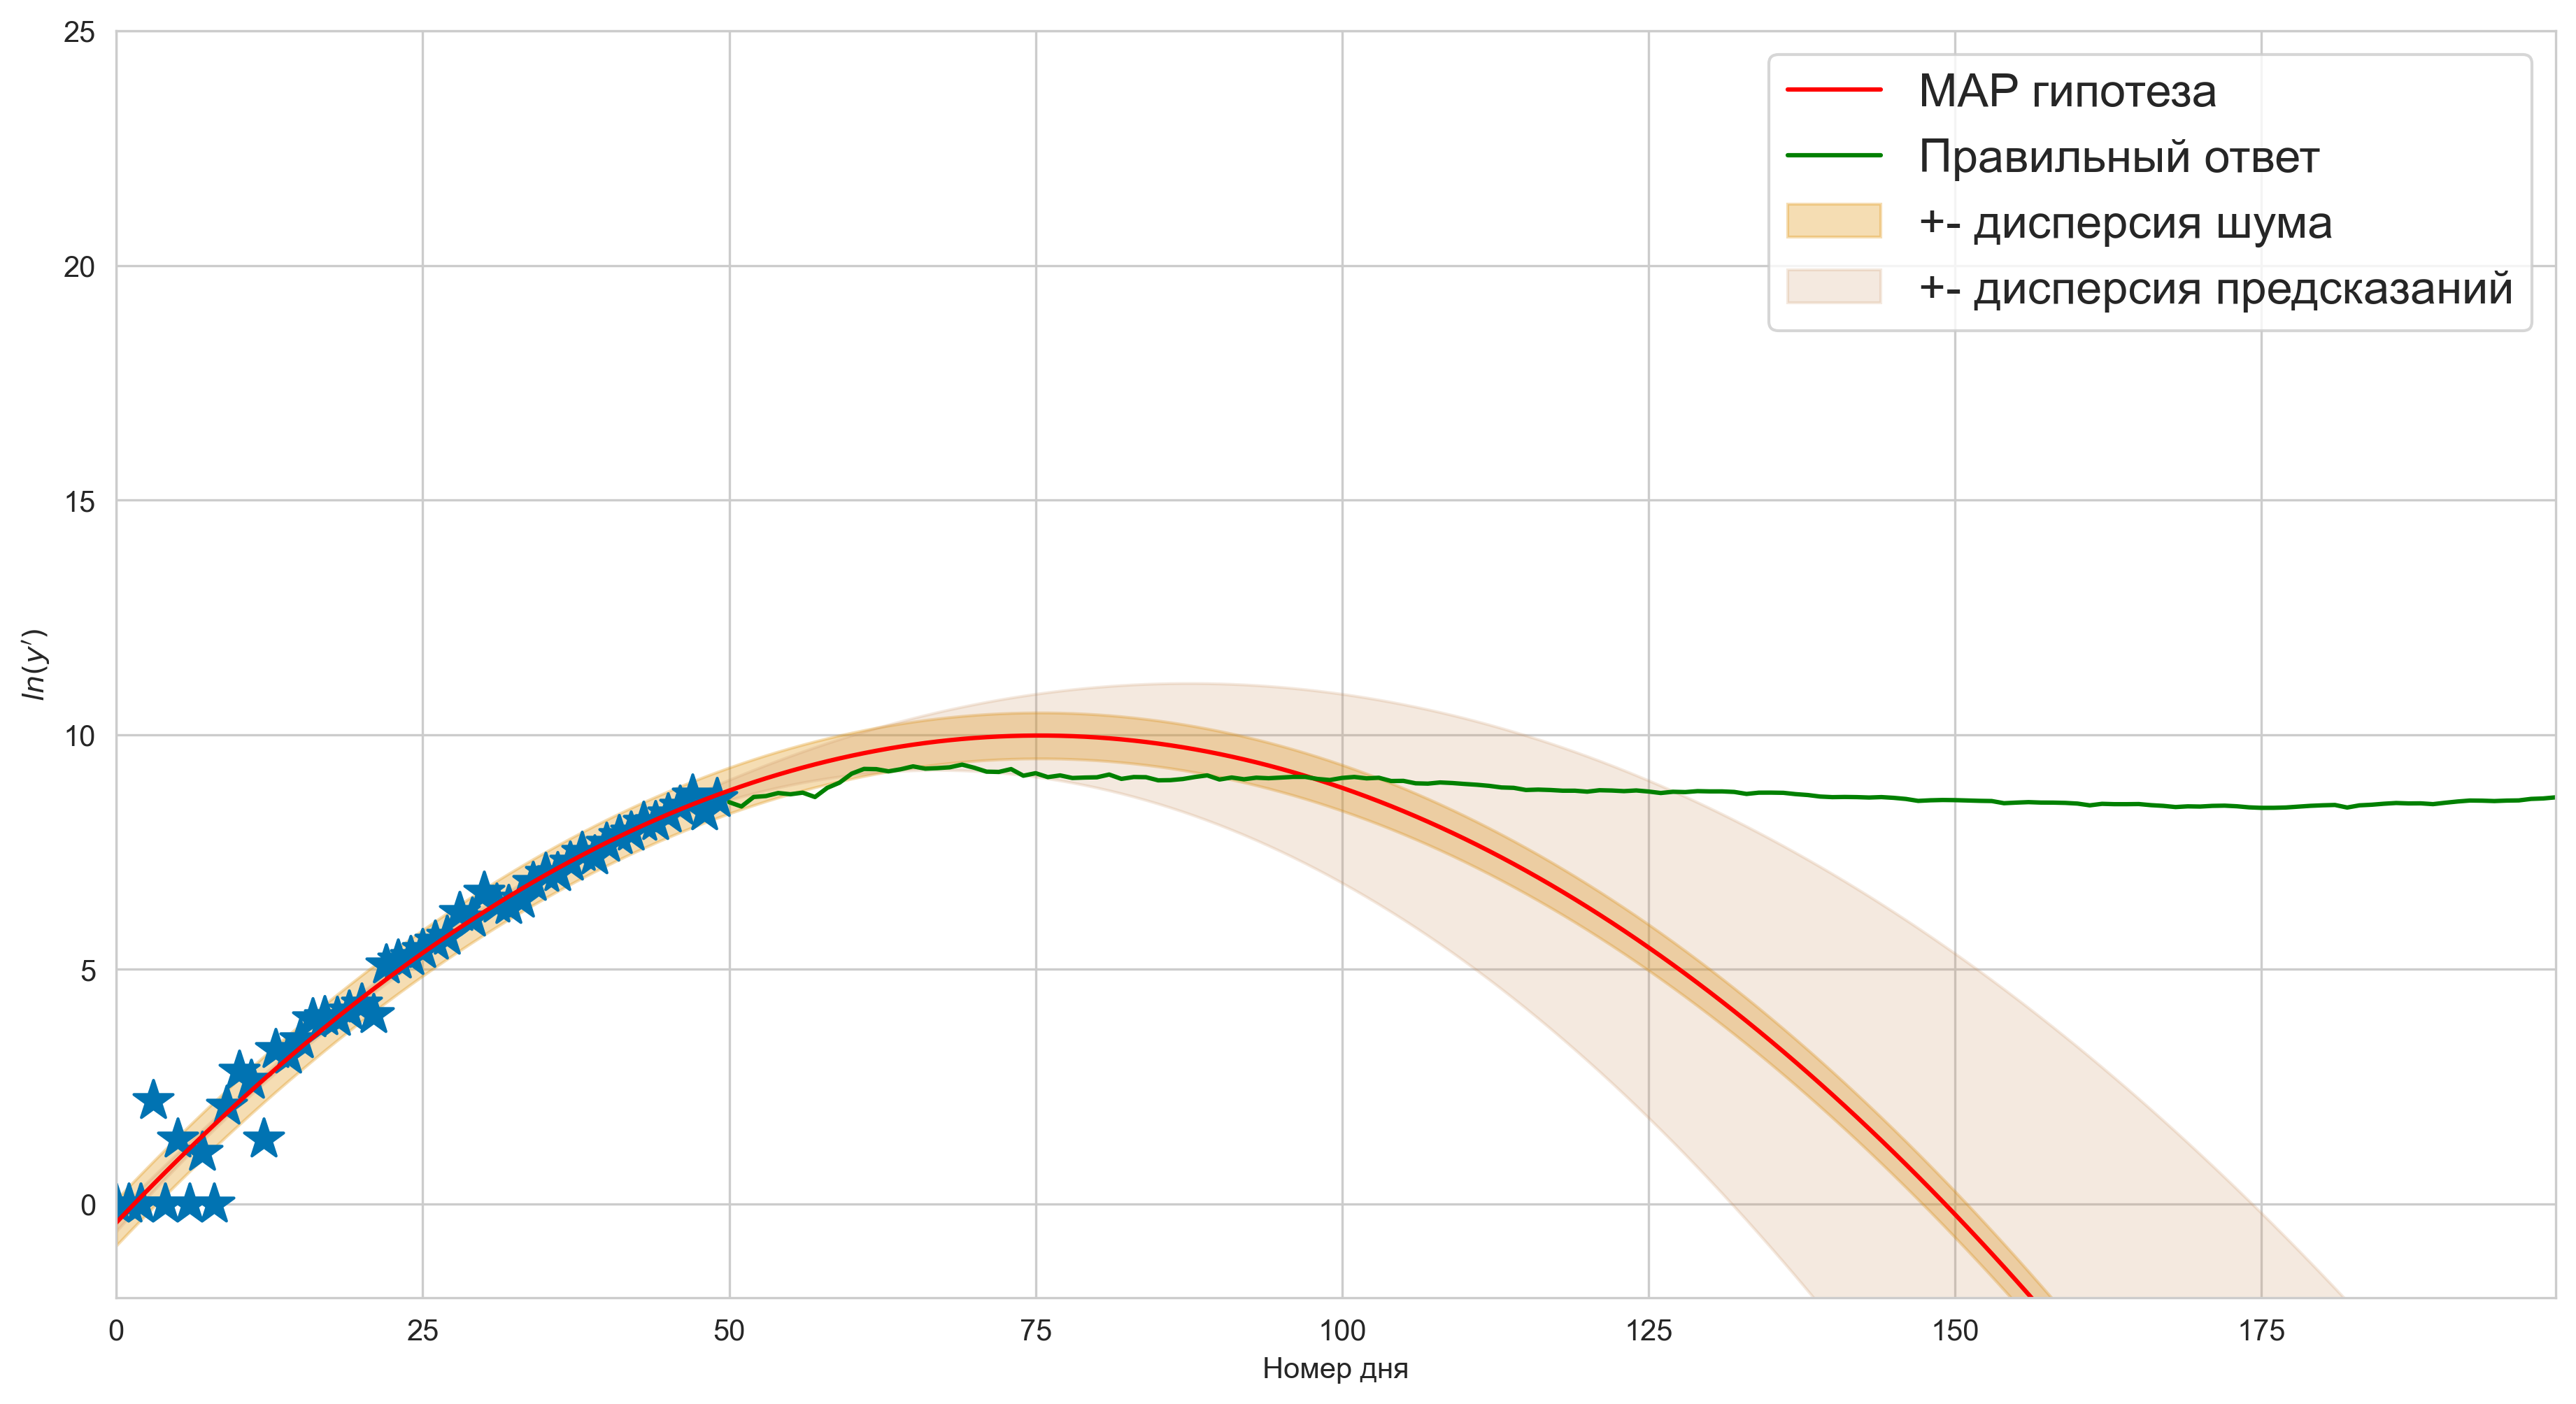

In [85]:
emperical_plot_predictions(np.arange(200), sigma_noise, cur_mu, x)

МАР гипотеза и интервалы дисперсий шума данных и предсказаний для 200 точек, исходя из параметров гауссиана 
предсказательного распределения для каждой точки

In [86]:
# Мат. ожидание и среднеквадратическое отклонение предсказательного распределения
pred_mu = lambda x: cur_mu[0] + cur_mu[1] * x + cur_mu[2] * x**2
pred_sigma = lambda x: np.sqrt(sigma_noise ** 2 + (np.array([[1., x, x**2]]).dot(cur_sigma)).dot(np.array([[1., x, x**2]]).T)[0][0]) 

In [87]:
def plot_predictions(xs, noise):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.set_xlim((xs[0], xs[-1]))
    ax.set_ylim((-2, 20))
    ax.plot(xs, pred_mu(xs), color="red", label="MAP гипотеза")
    ax.fill_between(xs, pred_mu(xs) - noise, pred_mu(xs) + noise, color=palette[1], alpha=.3, label="+- дисперсия шума")
    ax.fill_between(xs, pred_mu(xs) - pred_sigma(xs), pred_mu(xs) + pred_sigma(xs), color=palette[5], alpha=.2, label="+- дисперсия предсказаний")
    ax.scatter(train.num_day.values, np.log(train.new_cases.values), marker='*', s=200, label='Train set')
    ax.plot(test.num_day.values, np.log(test.new_cases.values), c='g', label='Правильный ответ')
    ax.set_xlabel('Номер дня')
    ax.set_ylabel('$ln(y\')$')
    ax.legend(fontsize=legend_fontsize)

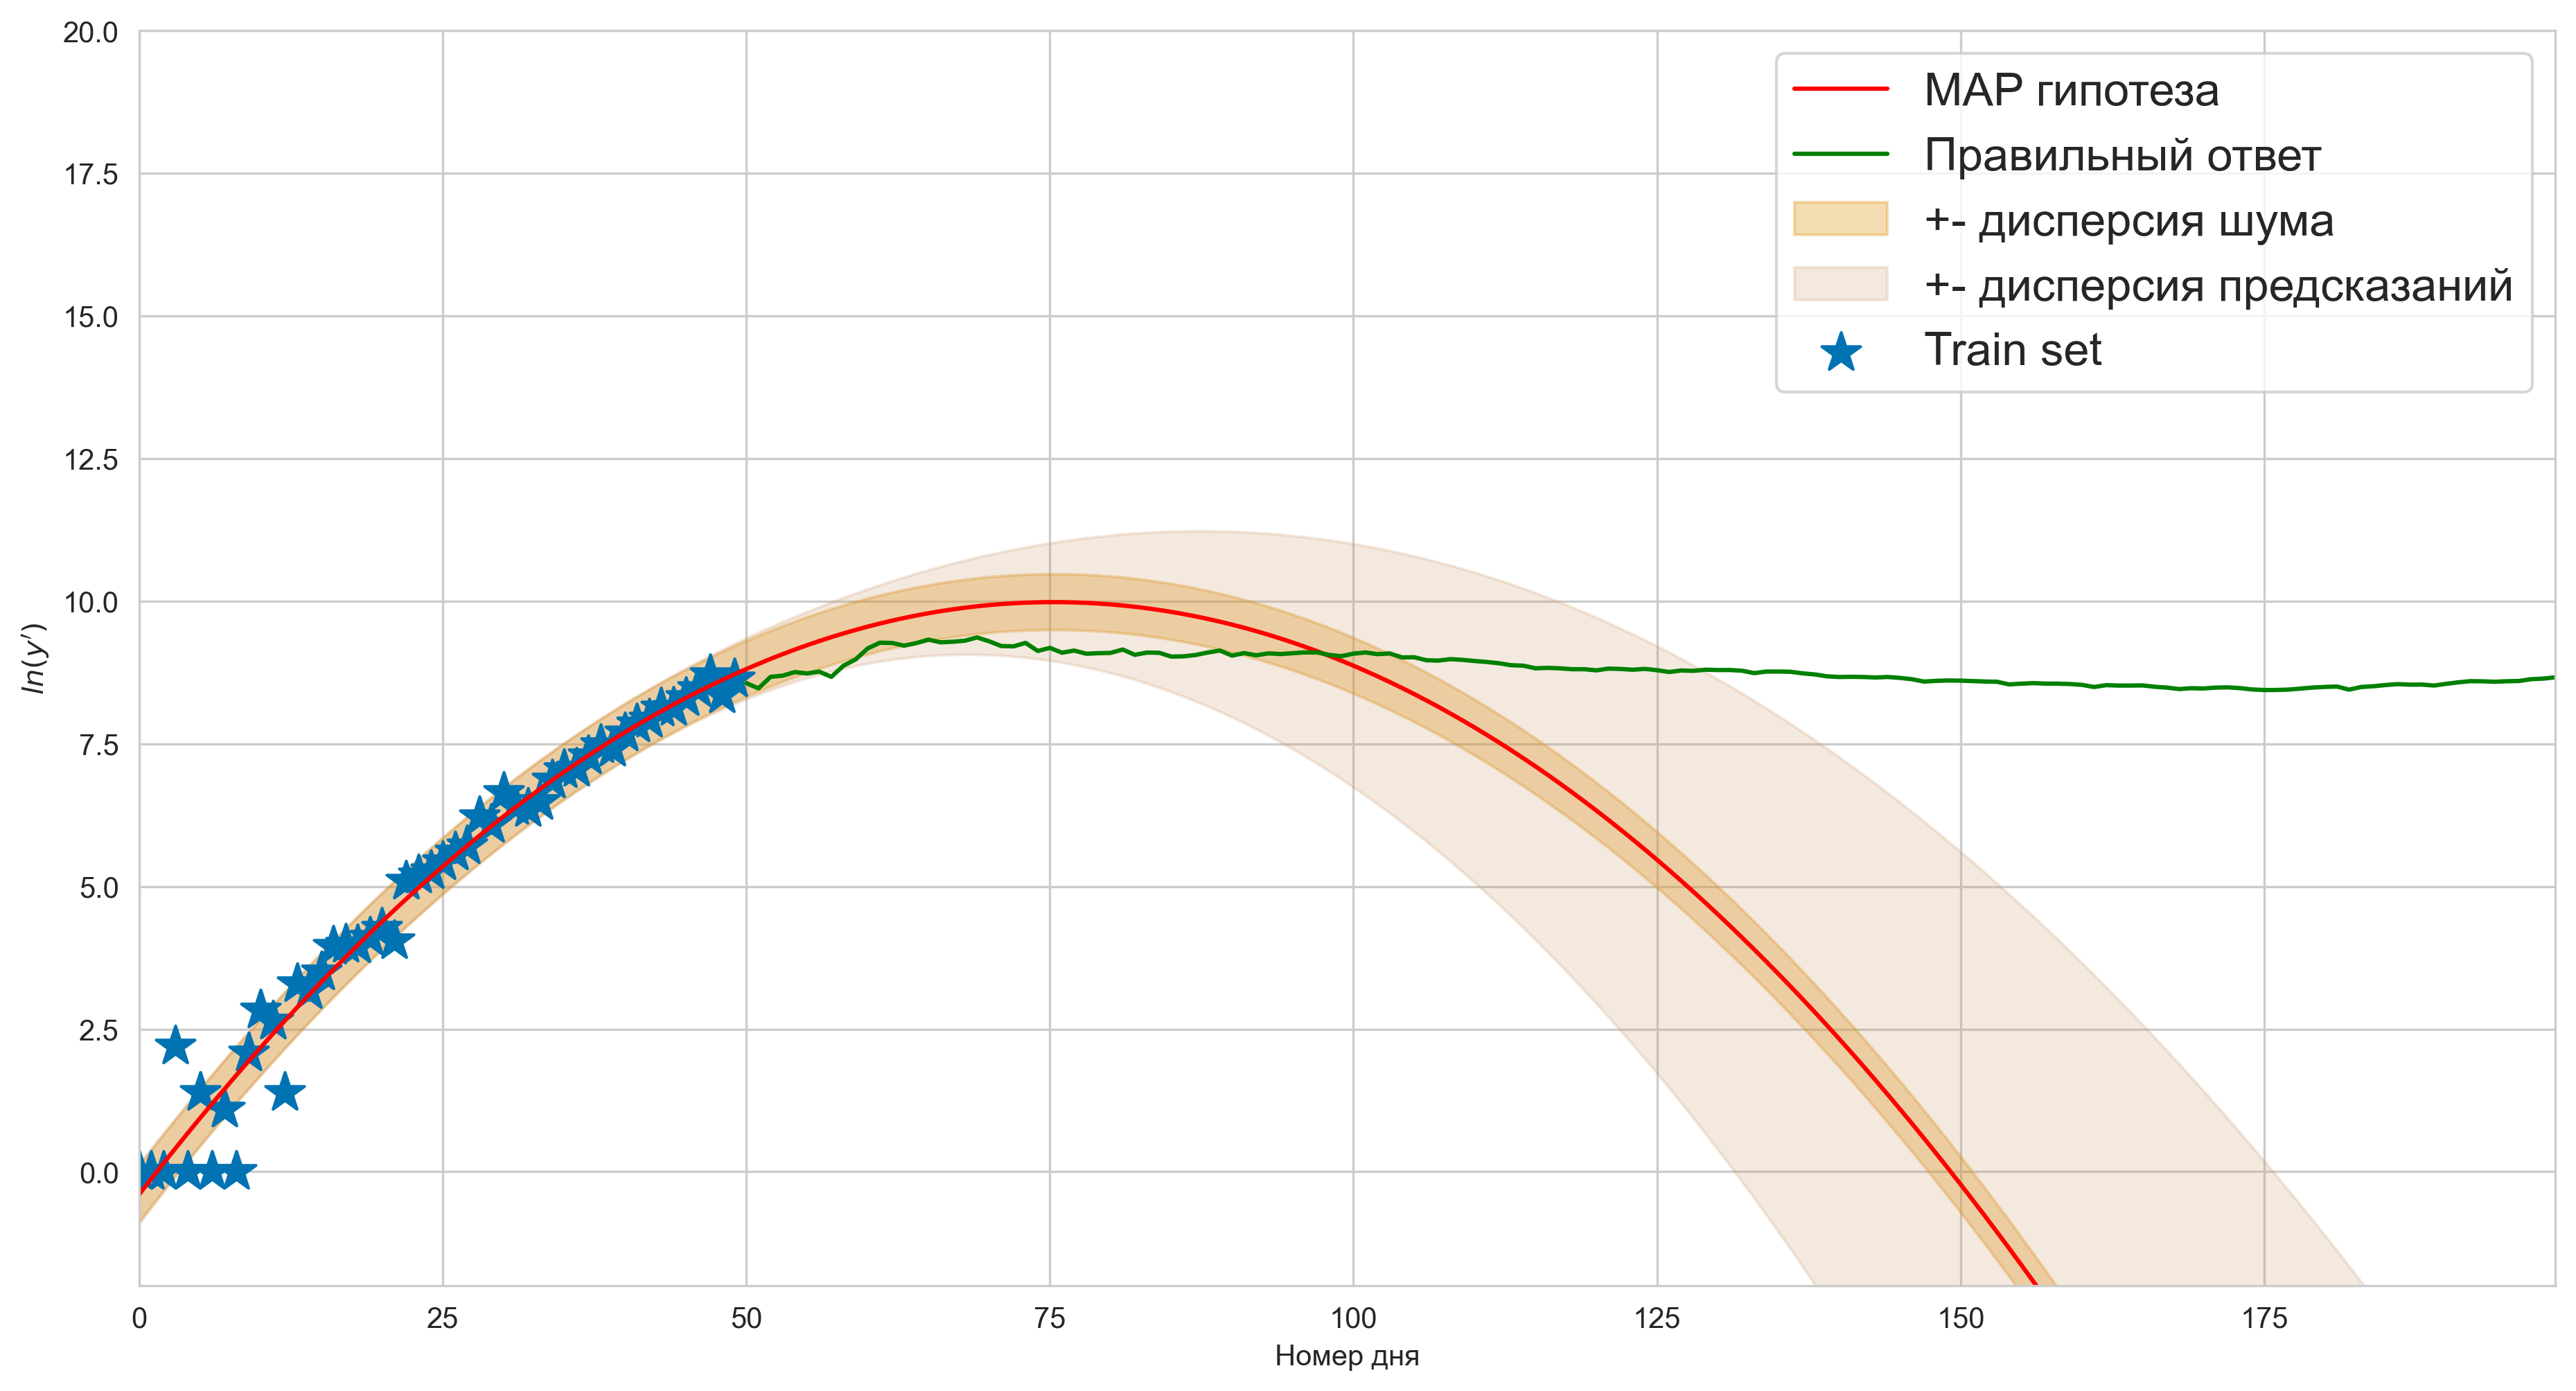

In [88]:
plot_predictions(np.arange(200), sigma_noise)

Графики на основе эмпирических данных и на основе параметров гауссиана предсказательного распределения 
получились идентичными.

In [89]:
total = total[total < np.quantile(total, 0.99)]
print('Исходя из данных сэмплирования:')
print(f'Всего случаев коронавируса в России: {int(np.mean(total))}')
print(f'Количество заболевших при оптимистичном сценарии: {int(np.percentile(total, 10))}')
print(f'Количество заболевших при пессимистичном сценарии: {int(np.percentile(total, 90))}')

Исходя из данных сэмплирования:
Всего случаев коронавируса в России: 2095711
Количество заболевших при оптимистичном сценарии: 329622
Количество заболевших при пессимистичном сценарии: 4082267


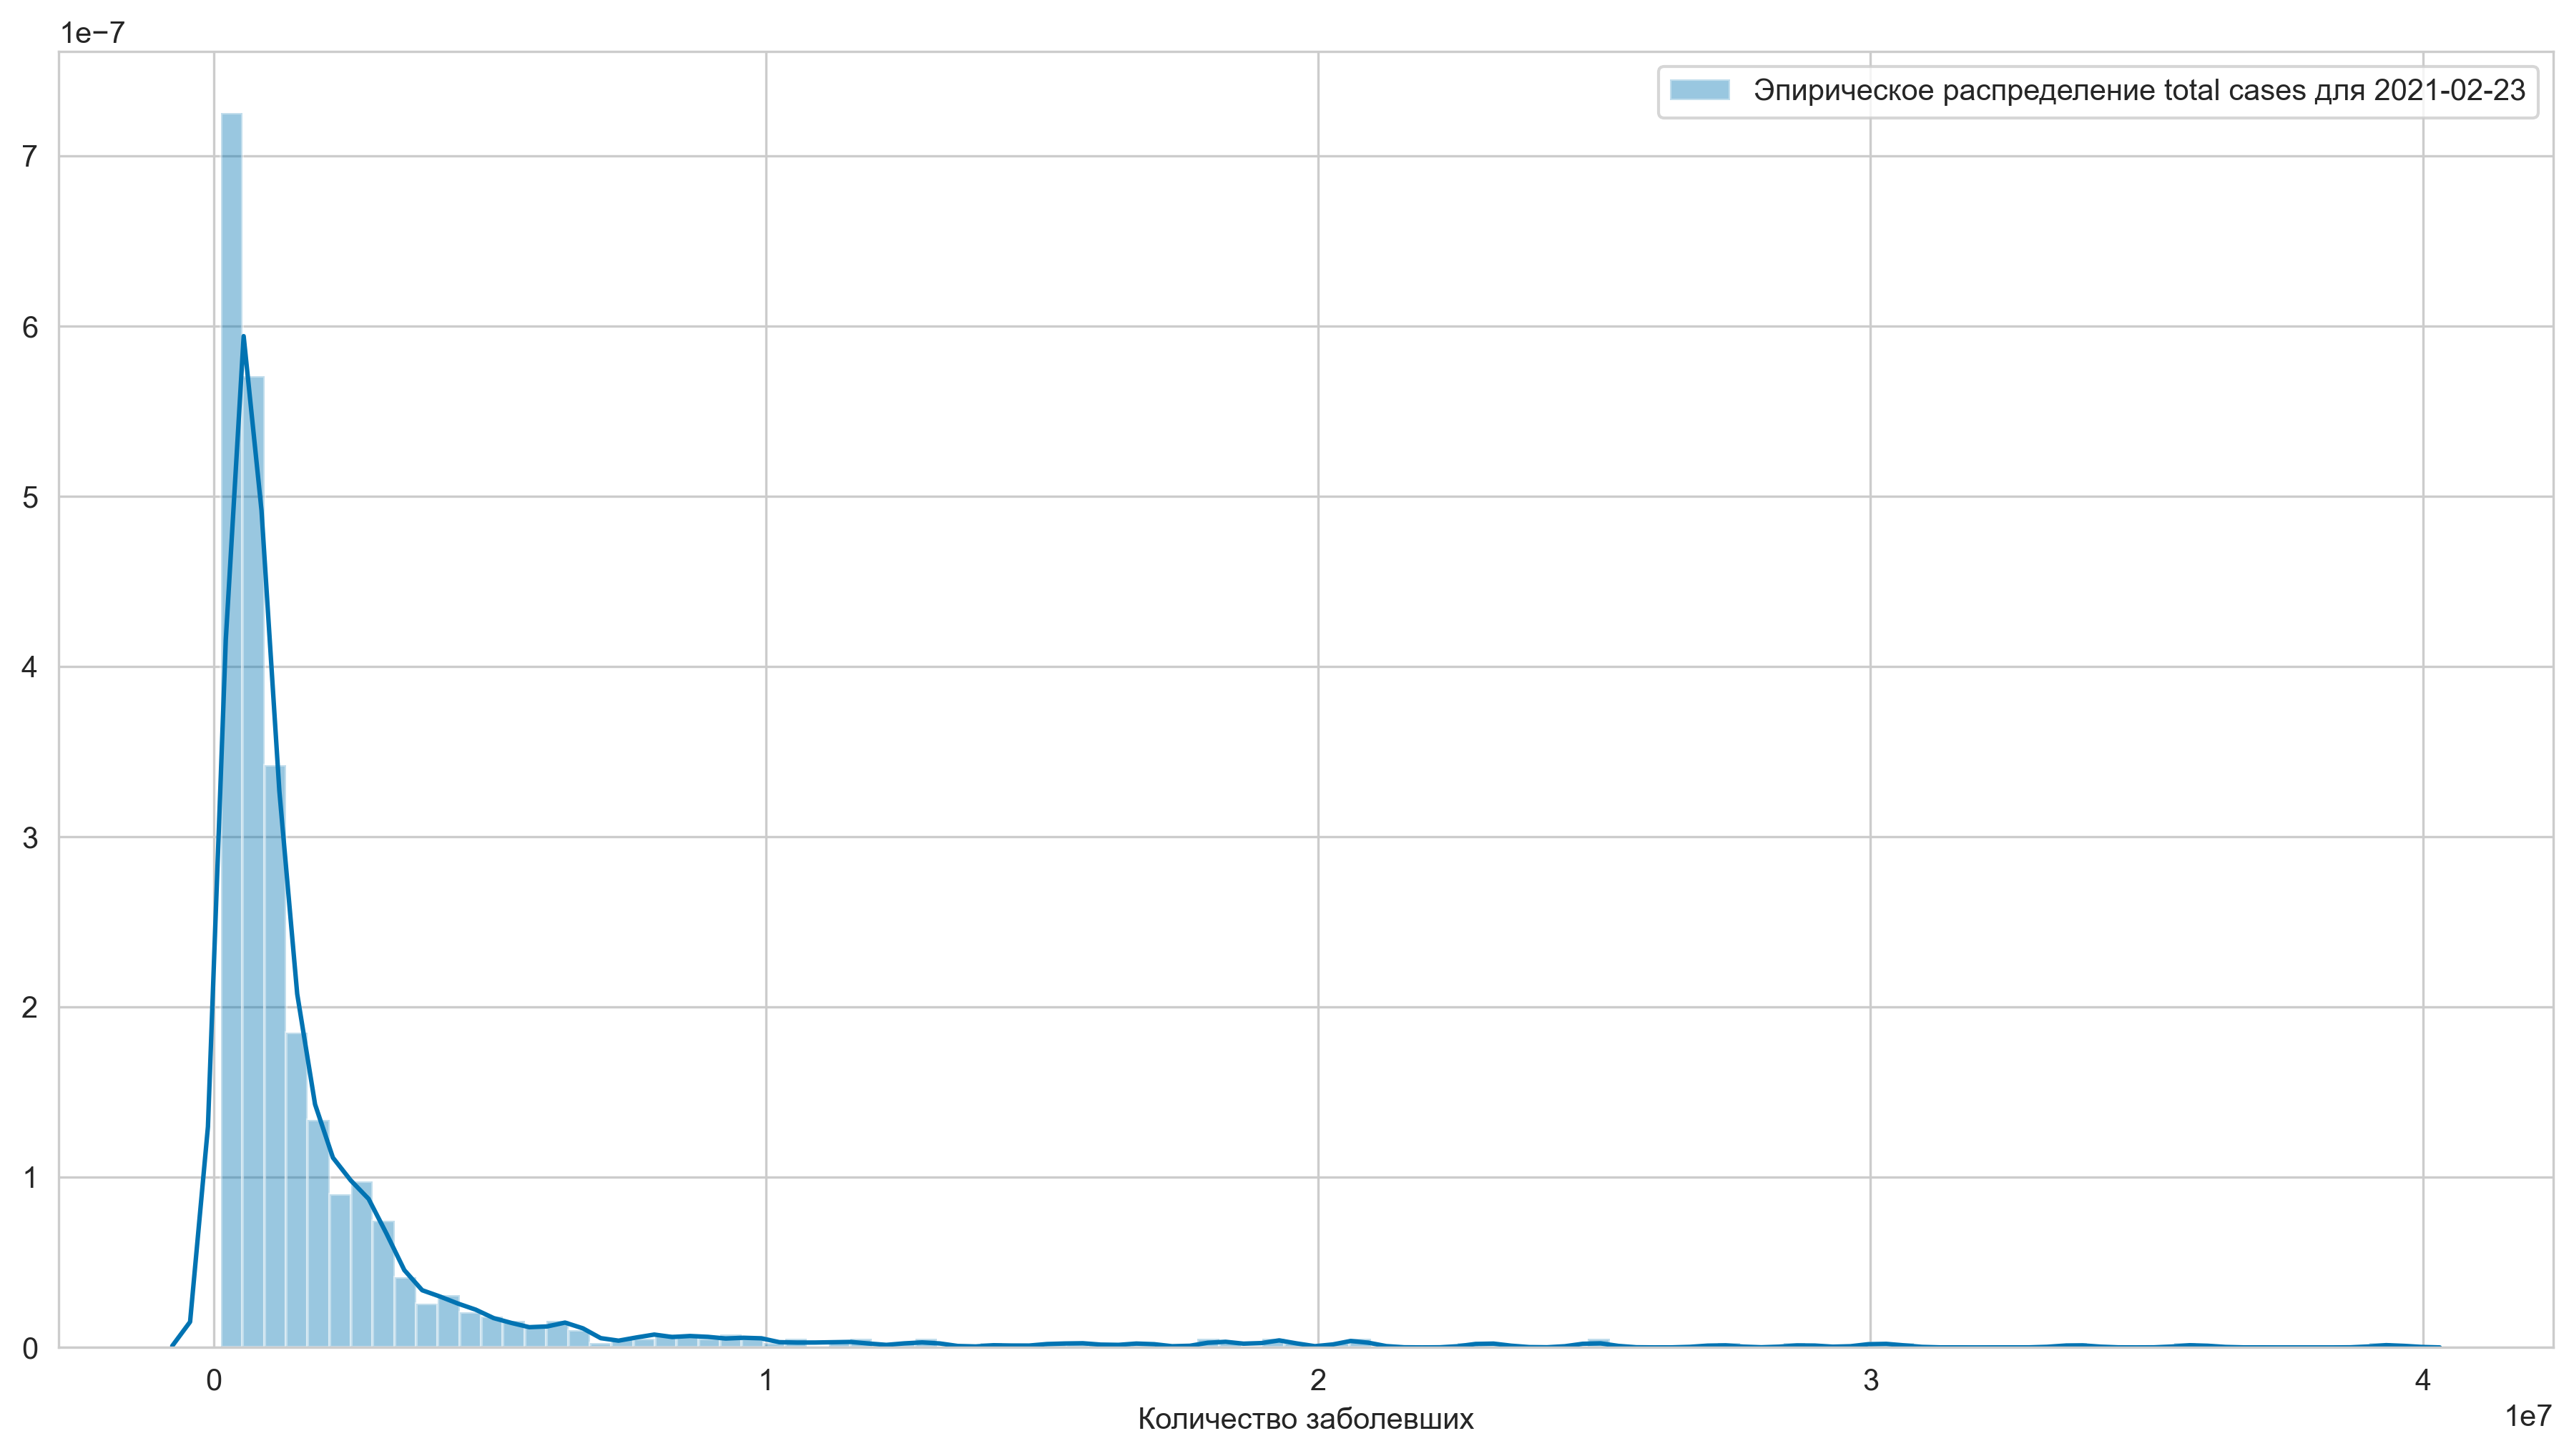

In [118]:
sns.distplot(total, bins=100, hist=True, kde=True, 
             label='Эпирическое распределение total cases для 2021-02-23')
plt.xlabel('Количество заболевших')
plt.legend()
plt.show()